# MNIST classification example with TensorFlow

## Install packages on Google  Cloud Datalab (locally use conda env)

### Select in the Python3 Kernel:
In the menu bar the of 'Kernel', select   
**python3**
### Install needed packages
copy the command below in a Google Cloud Datalab cell  
**!pip install tensorflow==2.0.0-alpha0**
### Restart the Kernel 
this is to take into account the new installed packages. Click in the menu bar on:  
**Reset Session**

## Include paths to our functions

In [1]:
import sys
import os
import pathlib

workingdir=os.getcwd()
print(workingdir)
d=[d for d in os.listdir(workingdir)]
n=0
while not set(['notebook']).issubset(set(d)):
    workingdir=str(pathlib.Path(workingdir).parents[0])
    print(workingdir)
    d=[d for d in os.listdir(str(workingdir))]
    n+=1
    if n>5:
        break
sys.path.insert(0, workingdir)
os.chdir(workingdir)

/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP/notebook/TF_2.0
/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP/notebook
/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP


## Setup librairies import and plots style

### Import librairies

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from absl import logging
from absl import flags
import seaborn as sns
import numpy as np
import itertools
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from skimage.segmentation import mark_boundaries
from skimage.color import gray2rgb, rgb2gray, label2rgb
import _pickle as cPickle
import lime
from lime import lime_image
from random import sample, randint, shuffle
import time
import shutil
import glob
import re
import codecs
import json 
import subprocess
import requests
import google.auth

In [3]:
print(tf.__version__)
print(tf.keras.__version__)

2.0.0-dev20190725
2.2.4-tf


### Import our utils functions

In [4]:
import src.utils.mnist_utils as mnist_utils
import src.utils.ml_utils as ml_utils
import src.utils.tensorflow_helper as tensorflow_helper
import src.model_mnist_2_0_v1.trainer.model as mnist_v1

Current Working direcotory:	/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP


In [5]:
import importlib
importlib.reload(mnist_utils)
importlib.reload(mnist_v1)
importlib.reload(ml_utils)
importlib.reload(tensorflow_helper);# to reload the function and mask the output

### Set plots style

In [6]:
print(plt.style.available)

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [7]:
# color code: https://matplotlib.org/gallery/color/named_colors.html#sphx-glr-gallery-color-named-colors-py
plt.style.use('seaborn-ticks')

## Data visualization of some examples per classes

### Loading dataset

In [8]:
path_train='data/mnist/numpy_train/'
path_test='data/mnist/numpy_test/'
x_train=cPickle.load(open(path_train+'x_train.pkl', 'rb'))
y_train=cPickle.load(open(path_train+'y_train.pkl', 'rb'))
x_test=cPickle.load(open(path_test+'x_test.pkl', 'rb'))
y_test=cPickle.load(open(path_test+'y_test.pkl', 'rb'))

### Looking at some example from training dataset

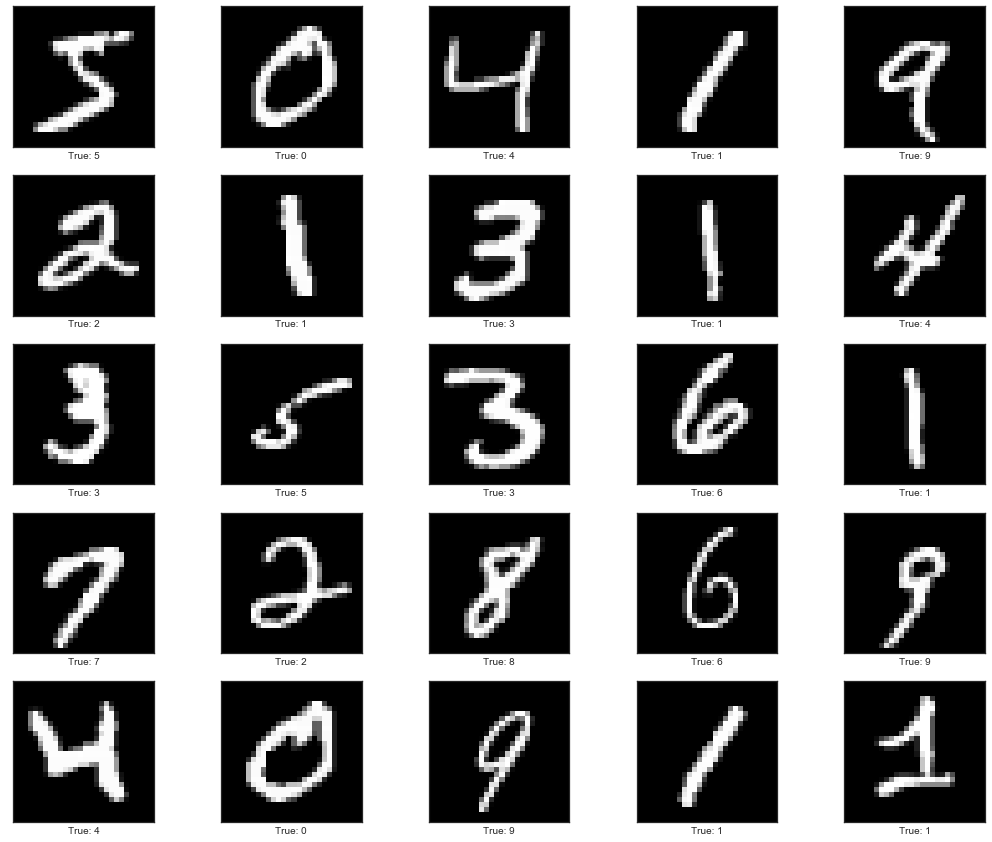

In [9]:
mnist_utils.plot_mnist_images(x_train[0:25], y_train[0:25])

## Set parameter

In [10]:
logging.set_verbosity(logging.INFO)
#logging.set_verbosity(logging.DEBUG)

In [11]:
# number of classes
NUM_CLASSES =10

# dimension of the input data
DIM_INPUT = 784

# number of epoch to train our model
EPOCHS = 100

# number of step to train our model
STEPS = 1000

# size of our mini batch
BATCH_SIZE = 128

# shuffle buffer size
SHUFFLE_BUFFER_SIZE = 10 * BATCH_SIZE

# prefetch buffer size
PREFETCH_BUFFER_SIZE = tf.data.experimental.AUTOTUNE

# number of paralell calls
NUM_PARALELL_CALL = 4

# model name
MODEL_NAME='model_mnist_v1'

# Model Version
MODEL_VERSION = 'v3'

# GCP project name, will be extracted later
PROJECT = ''

# Name of the bucket
BUCKET = 'cloud-training-demos-ml'

# GCP region
REGION = 'us-central1'

# GCP Scale Tier
TIER = 'BASIC'

# Training Directory name
TRAINING_DIR = 'mnist_trained'

# TensforFlow Version
TF_VERSION = '1.12'

# Labels
RESOURCE_LABELS='team=machine-learning,phase=test,owner=fabien'

In [12]:
os.environ['PROJECT'] = subprocess.run('gcloud config list project --format "value(core.project)"', shell=True, check=True, stdout=subprocess.PIPE).stdout.decode().replace('\n', '')
os.environ['BUCKET'] = os.environ['PROJECT']
os.environ['REGION'] = REGION
os.environ['TIER'] = TIER
os.environ['MODEL_NAME'] = MODEL_NAME
os.environ['MODEL_VERSION'] = MODEL_VERSION
os.environ['TRAINING_DIR'] = TRAINING_DIR 
os.environ['TFVERSION'] = TF_VERSION
os.environ['RESOURCE_LABELS'] = RESOURCE_LABELS

## Input dataset
Use tf.data.dataset to feed the Keras model

In [13]:
# be sure you have the tfrecords file locally if you want to train localy (or get them from Cloud Storage)
path_test_tfrecords = 'data/mnist/tfrecords_image_test/*'
path_train_tfrecords = 'data/mnist/tfrecords_image_train/*'

## Defined flags

In [14]:
print(flags.FLAGS)


absl.app:
  --[no]only_check_args: Set to true to validate args and exit.
    (default: 'false')
  --[no]pdb_post_mortem: Set to true to handle uncaught exceptions with PDB post
    mortem.
    (default: 'false')
  --profile_file: Dump profile information to a file (for python -m pstats).
    Implies --run_with_profiling.
  --[no]run_with_pdb: Set to true for PDB debug mode
    (default: 'false')
  --[no]run_with_profiling: Set to true for profiling the script. Execution will
    be slower, and the output format might change over time.
    (default: 'false')
  --[no]use_cprofile_for_profiling: Use cProfile instead of the profile module
    for profiling. This has no effect unless --run_with_profiling is set.
    (default: 'true')

absl.logging:
  --[no]alsologtostderr: also log to stderr?
    (default: 'false')
  --log_dir: directory to write logfiles into
    (default: '')
  --[no]logtostderr: Should only log to stderr?
    (default: 'false')
  --[no]showprefixforinfo: If False, do n

In [15]:
tf_flags=['f', 'input_train_tfrecords', 'input_test_tfrecords', 'model_dir', 'saved_dir', 'epoch', 'step', 'step_per_epoch', 'batch_size', 'shuffle_buffer_size', 'prefetch_buffer_size', 'num_parallel_calls', 'num_classes', 'dim_input']
tensorflow_helper.del_all_flags(flags.FLAGS, tf_flags)

In [16]:
# just for jupyter notebook and avoir : "UnrecognizedFlagError: Unknown command line flag 'f'"
flags.DEFINE_string('f', '', 'kernel') 

# path to input data
flags.DEFINE_string('input_train_tfrecords', path_train_tfrecords, 'input folder of tfrecords training data')
flags.DEFINE_string('input_test_tfrecords', path_test_tfrecords, 'input folder of tfrecords testing data')


# path to store the model and input for Tensorboard and SavedModel
flags.DEFINE_string('model_dir', 'results/Models/Mnist/tf_1_12/estimator/'+MODEL_VERSION+'/ckpt/', 'Dir to save a model and checkpoints')
flags.DEFINE_string('saved_dir', 'results/Models/Mnist/tf_1_12/estimator/'+MODEL_VERSION+'/pt/', 'Dir to save a model for TF serving')

# parameters for the input dataset and train the model
flags.DEFINE_integer('epoch', EPOCHS, 'number of epoch')
flags.DEFINE_integer('step', STEPS, 'number of step')
flags.DEFINE_integer('step_per_epoch', len(x_train) // BATCH_SIZE, 'number of step per epoch')
flags.DEFINE_integer('batch_size', BATCH_SIZE, 'Batch size')
flags.DEFINE_integer('shuffle_buffer_size', SHUFFLE_BUFFER_SIZE , 'Shuffle buffer size')
flags.DEFINE_integer('prefetch_buffer_size', PREFETCH_BUFFER_SIZE, 'Prefetch buffer size')
flags.DEFINE_integer('num_parallel_calls', NUM_PARALELL_CALL, 'Number of paralell calls')

# parameters for the model
flags.DEFINE_integer('num_classes', NUM_CLASSES, 'number of classes in our model')
flags.DEFINE_integer('dim_input', DIM_INPUT, 'dimension of the input data for our model')

FLAGS = flags.FLAGS

# new with 2.0
FLAGS(sys.argv)

['/Users/tarrade/anaconda-release/conda-env/env_gcp_dl_2_0_nightly/lib/python3.6/site-packages/ipykernel_launcher.py']

In [17]:
print(FLAGS)


/Users/tarrade/anaconda-release/conda-env/env_gcp_dl_2_0_nightly/lib/python3.6/site-packages/ipykernel_launcher.py:
  --batch_size: Batch size
    (default: '128')
    (an integer)
  --dim_input: dimension of the input data for our model
    (default: '784')
    (an integer)
  --epoch: number of epoch
    (default: '100')
    (an integer)
  --f: kernel
    (default: '')
  --input_test_tfrecords: input folder of tfrecords testing data
    (default: 'data/mnist/tfrecords_image_test/*')
  --input_train_tfrecords: input folder of tfrecords training data
    (default: 'data/mnist/tfrecords_image_train/*')
  --model_dir: Dir to save a model and checkpoints
    (default: 'results/Models/Mnist/tf_1_12/estimator/v3/ckpt/')
  --num_classes: number of classes in our model
    (default: '10')
    (an integer)
  --num_parallel_calls: Number of paralell calls
    (default: '4')
    (an integer)
  --prefetch_buffer_size: Prefetch buffer size
    (default: '-1')
    (an integer)
  --saved_dir: Dir to

In [18]:
# pre defined flags
tf.estimator.ModeKeys.EVAL, tf.estimator.ModeKeys.PREDICT, tf.estimator.ModeKeys.TRAIN

('eval', 'infer', 'train')

### Printing the number relater to the number of events (epoch, batch size, ...)

In [19]:
def print_summary_input(data, step='training'):
    print('Summary for the {} dataset:'.format(step))
    if step=='training':
        print('  - number of epoch            :', FLAGS.epoch)
        print('  - number of events per epoch :', len(data))
        print('  - batch size                 :', FLAGS.batch_size)
        print('  - number of step per epoch   :', FLAGS.step_per_epoch)
        print('  - total number of steps      :', FLAGS.epoch * FLAGS.step_per_epoch)
    else:
        print('  - number of epoch            :', 1)
        print('  - number of events per epoch :', len(data))
        print('  - batch size                 :', None)
        print('  - number of step per epoch   :', 1)
        print('  - total number of steps      :', 1)  

In [20]:
print_summary_input(x_train)

Summary for the training dataset:
  - number of epoch            : 100
  - number of events per epoch : 60000
  - batch size                 : 128
  - number of step per epoch   : 468
  - total number of steps      : 46800


In [21]:
print_summary_input(x_test, 'testing')

Summary for the testing dataset:
  - number of epoch            : 1
  - number of events per epoch : 10000
  - batch size                 : None
  - number of step per epoch   : 1
  - total number of steps      : 1


## Machine Learning modelling with Keras

### Deleting existing models
delete fist the folder for a clean start

In [22]:
print('trained model will be saved here:\n', FLAGS.model_dir)

trained model will be saved here:
 results/Models/Mnist/tf_1_12/estimator/v3/ckpt/


In [23]:
# deleting the folder from previous try 
shutil.rmtree(FLAGS.model_dir, ignore_errors=True)

In [24]:
print('trained model will be saved here:\n', FLAGS.saved_dir)

trained model will be saved here:
 results/Models/Mnist/tf_1_12/estimator/v3/pt/


In [25]:
# deleting the folder from previous try 
shutil.rmtree(FLAGS.saved_dir, ignore_errors=True)

### Build the model

In [26]:
# reset the model
tf.keras.backend.clear_session()

In [27]:
# build the model
model_opt_tf = mnist_v1.keras_baseline_model(FLAGS.dim_input, FLAGS.num_classes)

# store the origina weights
initial_weights = model_opt_tf.get_weights()

keras_baseline_model


### Check the nuber of parameters

In [28]:
model_opt_tf.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


### Check input and output layer names

In [29]:
model_opt_tf.input_names # Use this name as the dictionary key in the TF input function

['dense_input']

In [30]:
model_opt_tf.output_names

['dense_2']

### Use tf.distribute.startegy work across multiple devices/machines

In [31]:
# the tf.distribute.Strategy API is an easy way to distribute your training across multiple devices/machines
# works
strategy=None

# TF 2.0 bug 
# https://github.com/tensorflow/tensorflow/issues/27696
#strategy = tf.distribute.MirroredStrategy()
#strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()


# config tf.estimator to use a give strategy
training_config = tf.estimator.RunConfig(train_distribute=strategy,
                                         model_dir=FLAGS.model_dir,
                                         save_summary_steps=1,
                                         save_checkpoints_steps=100,
                                         keep_checkpoint_max=3,
                                         log_step_count_steps=10)

### Transform a keras model to estimator model

In [32]:
# Set to the original weights for testing other pipelines
model_opt_tf.set_weights(initial_weights)

# transfor keras model to estimator model
estimator_train_model = tf.keras.estimator.model_to_estimator(keras_model=model_opt_tf,
                                                              config=training_config)

I0726 21:16:57.441303 4668368320 keras.py:527] Using the Keras model provided.
W0726 21:16:57.449894 4668368320 deprecation.py:506] From /Users/tarrade/anaconda-release/conda-env/env_gcp_dl_2_0_nightly/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1633: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
W0726 21:16:57.856482 4668368320 deprecation.py:323] From /Users/tarrade/anaconda-release/conda-env/env_gcp_dl_2_0_nightly/lib/python3.6/site-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:468: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.
I0726 21:16:58.174586 46683

## Training and inference using  tf.estimator and tf.data.dataset

- **batch_size** determines the number of samples in each mini batch. Its maximum is the number of all samples, which makes gradient descent accurate, the loss will decrease towards the minimum if the learning rate is small enough, but iterations are slower. Its minimum is 1, resulting in stochastic gradient descent: Fast but the direction of the gradient step is based only on one example, the loss may jump around. batch_size allows to adjust between the two extremes: accurate gradient direction and fast iteration. Also, the maximum value for batch_size may be limited if your model + data set does not fit into the available (GPU) memory.
- **steps_per_epoch** the number of batch iterations before a training epoch is considered finished. If you have a training set of fixed size you can ignore it but it may be useful if you have a huge data set or if you are generating random data augmentations on the fly, i.e. if your training set has a (generated) infinite size. If you have the time to go through your whole training data set I recommend to skip this parameter.
- **validation_steps** similar to steps_per_epoch but on the validation data set instead on the training data. If you have the time to go through your whole validation data set I recommend to skip this parameter.



### Create some helper function

In [33]:
# need to be migrated to TF 2.0

Input dataset functions for training and testing will be pass during fit to load, convert, preprocess and reshuffle the images and labels 

### Train the  keras to estimator model locally

In [34]:
# drop all files except the keras folder before training
for x in glob.glob(FLAGS.model_dir+'*') :
    if 'keras' not in x:
        os.remove(x)

In [35]:
 for x in glob.glob(FLAGS.model_dir+'*') :
        print(x)

results/Models/Mnist/tf_1_12/estimator/v3/ckpt/keras


In [36]:
%%time
# need if file are removed with previous event files
#tf.summary.FileWriterCache.clear()

# Fit the model (using estimator.train and data.Dataset)
estimator_train_model.train(input_fn=lambda:mnist_v1.input_mnist_tfrecord_dataset_fn(path_train_tfrecords+'*',
                                                                                     FLAGS,
                                                                                     mode=tf.estimator.ModeKeys.TRAIN,
                                                                                     batch_size=FLAGS.batch_size),
                            steps=1000)

W0726 21:17:05.455307 4668368320 deprecation.py:323] From /Users/tarrade/anaconda-release/conda-env/env_gcp_dl_2_0_nightly/lib/python3.6/site-packages/tensorflow_core/python/training/training_util.py:236: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
I0726 21:17:05.465265 4668368320 model.py:211] input_dataset_fn: TRAIN, train
W0726 21:17:05.603504 4668368320 deprecation.py:323] From /Users/tarrade/anaconda-release/conda-env/env_gcp_dl_2_0_nightly/lib/python3.6/site-packages/tensorflow_core/python/data/util/random_seed.py:58: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
I0726 21:17:05.718662 4668368320 estimator.py:11

I0726 21:17:11.789818 4668368320 basic_session_run_hooks.py:692] global_step/sec: 48.6516
I0726 21:17:11.791437 4668368320 basic_session_run_hooks.py:260] loss = 0.3071276, step = 280 (0.205 sec)
I0726 21:17:11.946646 4668368320 basic_session_run_hooks.py:692] global_step/sec: 63.7556
I0726 21:17:11.947936 4668368320 basic_session_run_hooks.py:260] loss = 0.18876454, step = 290 (0.157 sec)
I0726 21:17:12.084879 4668368320 basic_session_run_hooks.py:606] Saving checkpoints for 300 into results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt.
I0726 21:17:12.207665 4668368320 basic_session_run_hooks.py:692] global_step/sec: 38.3145
I0726 21:17:12.209373 4668368320 basic_session_run_hooks.py:260] loss = 0.3181789, step = 300 (0.261 sec)
I0726 21:17:12.291486 4668368320 basic_session_run_hooks.py:692] global_step/sec: 119.32
I0726 21:17:12.292979 4668368320 basic_session_run_hooks.py:260] loss = 0.46063143, step = 310 (0.084 sec)
I0726 21:17:12.429531 4668368320 basic_session_run_hooks.py

I0726 21:17:17.451548 4668368320 basic_session_run_hooks.py:260] loss = 0.10186644, step = 640 (0.155 sec)
I0726 21:17:17.612854 4668368320 basic_session_run_hooks.py:692] global_step/sec: 61.4379
I0726 21:17:17.614207 4668368320 basic_session_run_hooks.py:260] loss = 0.35140866, step = 650 (0.163 sec)
I0726 21:17:17.768602 4668368320 basic_session_run_hooks.py:692] global_step/sec: 64.2062
I0726 21:17:17.769934 4668368320 basic_session_run_hooks.py:260] loss = 0.13131297, step = 660 (0.156 sec)
I0726 21:17:17.921161 4668368320 basic_session_run_hooks.py:692] global_step/sec: 65.5472
I0726 21:17:17.922413 4668368320 basic_session_run_hooks.py:260] loss = 0.36068618, step = 670 (0.152 sec)
I0726 21:17:18.115607 4668368320 basic_session_run_hooks.py:692] global_step/sec: 51.4353
I0726 21:17:18.116919 4668368320 basic_session_run_hooks.py:260] loss = 0.31381968, step = 680 (0.194 sec)
I0726 21:17:18.429633 4668368320 basic_session_run_hooks.py:692] global_step/sec: 31.8526
I0726 21:17:18.

CPU times: user 53.3 s, sys: 16.1 s, total: 1min 9s
Wall time: 18.4 s


In [37]:
for x in glob.glob(FLAGS.model_dir+'*') :
    print(x)

results/Models/Mnist/tf_1_12/estimator/v3/ckpt/keras
results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-700.index
results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-600.data-00000-of-00002
results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-600.data-00001-of-00002
results/Models/Mnist/tf_1_12/estimator/v3/ckpt/checkpoint
results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-600.index
results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-900.meta
results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-700.meta
results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-1000.meta
results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-800.data-00000-of-00002
results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-800.data-00001-of-00002
results/Models/Mnist/tf_1_12/estimator/v3/ckpt/graph.pbtxt
results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-900.index
results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-700.data-00001-of-00002
results/Models

In [38]:
from google.protobuf import text_format


# Let's read our pbtxt file into a Graph protobuf
f = open(FLAGS.model_dir+'graph.pbtxt', "r")
graph_protobuf = text_format.Parse(f.read(), tf.compat.v1.GraphDef())

# Import the graph protobuf into our new graph.
graph_clone = tf.Graph()
with graph_clone.as_default():
    tf.import_graph_def(graph_def=graph_protobuf, name="")

# Display the graph inline.
graph_clone.as_graph_def()

node {
  name: "global_step/Initializer/zeros"
  op: "Const"
  attr {
    key: "_class"
    value {
      list {
        s: "loc:@global_step"
      }
    }
  }
  attr {
    key: "dtype"
    value {
      type: DT_INT64
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT64
        tensor_shape {
        }
        int64_val: 0
      }
    }
  }
}
node {
  name: "global_step"
  op: "VarHandleOp"
  attr {
    key: "_class"
    value {
      list {
        s: "loc:@global_step"
      }
    }
  }
  attr {
    key: "container"
    value {
      s: ""
    }
  }
  attr {
    key: "dtype"
    value {
      type: DT_INT64
    }
  }
  attr {
    key: "shape"
    value {
      shape {
      }
    }
  }
  attr {
    key: "shared_name"
    value {
      s: "global_step"
    }
  }
}
node {
  name: "global_step/IsInitialized/VarIsInitializedOp"
  op: "VarIsInitializedOp"
  input: "global_step"
}
node {
  name: "global_step/Assign"
  op: "AssignVariableOp"
  input: "glo

### Visualize the keras to estimator model train

In [39]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard  --logdir   {FLAGS.model_dir} 

!kill 84277

In [39]:
# Bug TF 1.12 and TF 2.0
# Issue missing accurary for model to estimator https://github.com/tensorflow/tensorflow/issues/26804

W0726 21:22:09.925307 4668368320 event_accumulator.py:344] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0726 21:22:09.927472 4668368320 event_accumulator.py:352] Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
I0726 21:22:09.952741 4668368320 directory_watcher.py:118] No path found after results/Models/Mnist/tf_1_12/estimator/v3/ckpt/events.out.tfevents.1564168626.Fabien-Tarrades-MacBook-Pro.local
W0726 21:22:09.994271 4668368320 legend.py:1282] No handles with labels found to put in legend.




keras
model.ckpt-700.index
model.ckpt-600.data-00000-of-00002
model.ckpt-600.data-00001-of-00002
checkpoint
model.ckpt-600.index
model.ckpt-900.meta
model.ckpt-700.meta
model.ckpt-1000.meta
model.ckpt-800.data-00000-of-00002
model.ckpt-800.data-00001-of-00002
graph.pbtxt
model.ckpt-900.index
model.ckpt-700.data-00001-of-00002
model.ckpt-700.data-00000-of-00002
model.ckpt-1000.data-00001-of-00002
model.ckpt-1000.data-00000-of-00002
model.ckpt-800.index
model.ckpt-800.meta
events.out.tfevents.1564168626.Fabien-Tarrades-MacBook-Pro.local
model.ckpt-900.data-00001-of-00002
model.ckpt-900.data-00000-of-00002
model.ckpt-1000.index
model.ckpt-600.meta


dict_keys(['global_step/sec', 'loss_1'])




Loss:
  - loss [training dataset]: 0.150

Accuracy:


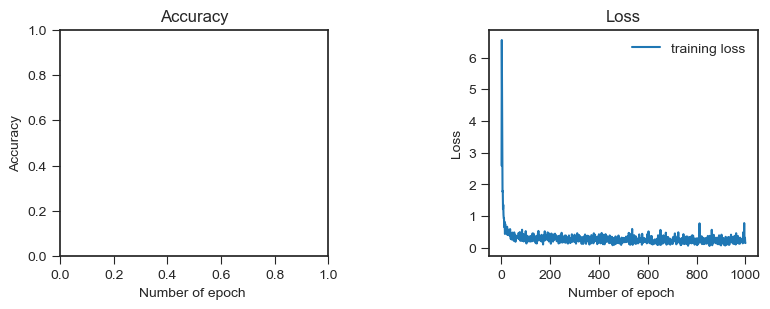

In [40]:
debug=True
history_train=ml_utils.load_data_tensorboard(FLAGS.model_dir)
if debug:
    print('\n')
    for file in glob.glob(FLAGS.model_dir+'*'):
        print(re.findall(r'[^\\/]+|[\\/]',file)[-1])
    print('\n')
    print(history_train.keys())
print('\n\n\n')
ml_utils.plot_acc_loss(history_train['loss_1'][0],history_train['loss_1'][1])

### Evaluate the  keras to estimator model locally

In [41]:
metric=estimator_train_model.evaluate(input_fn=lambda:mnist_v1.input_mnist_tfrecord_dataset_fn(path_test_tfrecords+'*',
                                                                                               FLAGS,
                                                                                               mode=tf.estimator.ModeKeys.EVAL,
                                                                                               batch_size=10000),
                                      steps=1),

I0726 21:22:14.662000 4668368320 model.py:209] input_dataset_fn: EVAL, eval
I0726 21:22:14.705948 4668368320 estimator.py:1145] Calling model_fn.
I0726 21:22:14.859345 4668368320 estimator.py:1147] Done calling model_fn.
I0726 21:22:14.887819 4668368320 evaluation.py:255] Starting evaluation at 2019-07-26T21:22:14Z
I0726 21:22:14.950485 4668368320 monitored_session.py:240] Graph was finalized.
I0726 21:22:14.952511 4668368320 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-1000
I0726 21:22:15.010037 4668368320 session_manager.py:500] Running local_init_op.
I0726 21:22:15.026145 4668368320 session_manager.py:502] Done running local_init_op.
I0726 21:22:16.070365 4668368320 evaluation.py:167] Evaluation [1/1]
I0726 21:22:16.097391 4668368320 evaluation.py:275] Finished evaluation at 2019-07-26-21:22:16
I0726 21:22:16.099742 4668368320 estimator.py:2040] Saving dict for global step 1000: accuracy = 0.9561, global_step = 1000, loss = 0.167

In [42]:
metric

({'accuracy': 0.9561, 'loss': 0.16788499, 'global_step': 1000},)

### Train and evaluate the  keras to estimator model locally

In [43]:
#%%time
# Delete both saved and checkpointed models
shutil.rmtree(FLAGS.model_dir, ignore_errors=True)
shutil.rmtree(FLAGS.saved_dir, ignore_errors=True)

# chcking files that are present
for x in glob.glob(FLAGS.model_dir+'*') :
    print(x)

# need if file are removed with previous event files
#tf.summary.FileWriterCache.clear()

# Reset Keras
tf.keras.backend.clear_session()

logging.set_verbosity(logging.DEBUG)
# Fit the model (using estimator.train and data.Dataset)
mnist_v1.train_and_evaluate(FLAGS, use_keras=True)

I0726 21:22:18.459504 4668368320 keras.py:527] Using the Keras model provided.


using keras model in estimator
keras_baseline_model


I0726 21:22:18.960458 4668368320 estimator.py:209] Using config: {'_model_dir': 'results/Models/Mnist/tf_1_12/estimator/v3/ckpt/', '_tf_random_seed': None, '_save_summary_steps': 10, '_save_checkpoints_steps': 10, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 3, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 50, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c3a045c18>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
I0726 21:22:18.961683 4668368320 estimator_training.py:186] Not using Dis

step 1-1
step 1-2
step 1-3


I0726 21:22:19.631565 4668368320 estimator.py:1147] Done calling model_fn.
I0726 21:22:19.632442 4668368320 estimator.py:1365] Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='results/Models/Mnist/tf_1_12/estimator/v3/ckpt/keras/keras_model.ckpt', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
I0726 21:22:19.633076 4668368320 warm_starting_util.py:462] Warm-starting from: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/keras/keras_model.ckpt
I0726 21:22:19.633856 4668368320 warm_starting_util.py:341] Warm-starting variables only in TRAINABLE_VARIABLES.
I0726 21:22:19.636848 4668368320 warm_starting_util.py:522] Warm-starting variable: dense/kernel; prev_var_name: layer_with_weights-0/kernel/.ATTRIBUTES/VARIABLE_VALUE
I0726 21:22:19.637619 4668368320 warm_starting_util.py:522] Warm-starting variable: dense/bias; prev_var_name: layer_with_weights-0/bias/.ATTRIBUTES/VARIABLE_VALUE
I0726 21:22:19.638406 4668368320 warm_start

I0726 21:22:26.888351 4668368320 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-40
I0726 21:22:26.935230 4668368320 session_manager.py:500] Running local_init_op.
I0726 21:22:26.951127 4668368320 session_manager.py:502] Done running local_init_op.
I0726 21:22:27.943773 4668368320 evaluation.py:167] Evaluation [1/1]
I0726 21:22:27.968422 4668368320 evaluation.py:275] Finished evaluation at 2019-07-26-21:22:27
I0726 21:22:27.969692 4668368320 estimator.py:2040] Saving dict for global step 40: accuracy = 0.9118, global_step = 40, loss = 0.29521254
I0726 21:22:27.970817 4668368320 estimator.py:2100] Saving 'checkpoint_path' summary for global step 40: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-40
I0726 21:22:28.074031 4668368320 basic_session_run_hooks.py:606] Saving checkpoints for 50 into results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt.
I0726 21:22:28.187364 4668368320 model.py:209] input_dataset_fn: EVAL, eval


I0726 21:22:37.505383 4668368320 session_manager.py:500] Running local_init_op.
I0726 21:22:37.519770 4668368320 session_manager.py:502] Done running local_init_op.
I0726 21:22:38.517805 4668368320 evaluation.py:167] Evaluation [1/1]
I0726 21:22:38.537877 4668368320 evaluation.py:275] Finished evaluation at 2019-07-26-21:22:38
I0726 21:22:38.538682 4668368320 estimator.py:2040] Saving dict for global step 100: accuracy = 0.9267, global_step = 100, loss = 0.23713627
I0726 21:22:38.539462 4668368320 estimator.py:2100] Saving 'checkpoint_path' summary for global step 100: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-100
I0726 21:22:38.555408 4668368320 basic_session_run_hooks.py:692] global_step/sec: 5.56283
I0726 21:22:38.557239 4668368320 basic_session_run_hooks.py:260] loss = 0.40178552, step = 100 (8.988 sec)
I0726 21:22:38.664052 4668368320 basic_session_run_hooks.py:606] Saving checkpoints for 110 into results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt.
I0726 21:

I0726 21:22:47.811493 4668368320 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-160
I0726 21:22:47.861488 4668368320 session_manager.py:500] Running local_init_op.
I0726 21:22:47.875777 4668368320 session_manager.py:502] Done running local_init_op.
I0726 21:22:48.905580 4668368320 evaluation.py:167] Evaluation [1/1]
I0726 21:22:48.937510 4668368320 evaluation.py:275] Finished evaluation at 2019-07-26-21:22:48
I0726 21:22:48.939639 4668368320 estimator.py:2040] Saving dict for global step 160: accuracy = 0.9366, global_step = 160, loss = 0.21877818
I0726 21:22:48.948194 4668368320 estimator.py:2100] Saving 'checkpoint_path' summary for global step 160: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-160
I0726 21:22:49.098329 4668368320 basic_session_run_hooks.py:606] Saving checkpoints for 170 into results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt.
I0726 21:22:49.244558 4668368320 model.py:209] input_dataset_fn: EVAL,

I0726 21:22:58.892873 4668368320 session_manager.py:500] Running local_init_op.
I0726 21:22:58.906181 4668368320 session_manager.py:502] Done running local_init_op.
I0726 21:22:59.864399 4668368320 evaluation.py:167] Evaluation [1/1]
I0726 21:22:59.889456 4668368320 evaluation.py:275] Finished evaluation at 2019-07-26-21:22:59
I0726 21:22:59.890328 4668368320 estimator.py:2040] Saving dict for global step 220: accuracy = 0.9392, global_step = 220, loss = 0.20859148
I0726 21:22:59.891735 4668368320 estimator.py:2100] Saving 'checkpoint_path' summary for global step 220: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-220
I0726 21:22:59.986015 4668368320 basic_session_run_hooks.py:606] Saving checkpoints for 230 into results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt.
I0726 21:23:00.128834 4668368320 model.py:209] input_dataset_fn: EVAL, eval
I0726 21:23:00.186076 4668368320 estimator.py:1145] Calling model_fn.
I0726 21:23:00.378443 4668368320 estimator.py:1147] Done cal

I0726 21:23:09.534152 4668368320 session_manager.py:502] Done running local_init_op.
I0726 21:23:10.594014 4668368320 evaluation.py:167] Evaluation [1/1]
I0726 21:23:10.616140 4668368320 evaluation.py:275] Finished evaluation at 2019-07-26-21:23:10
I0726 21:23:10.617259 4668368320 estimator.py:2040] Saving dict for global step 280: accuracy = 0.9411, global_step = 280, loss = 0.20442678
I0726 21:23:10.618896 4668368320 estimator.py:2100] Saving 'checkpoint_path' summary for global step 280: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-280
I0726 21:23:10.727756 4668368320 basic_session_run_hooks.py:606] Saving checkpoints for 290 into results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt.
I0726 21:23:10.860728 4668368320 model.py:209] input_dataset_fn: EVAL, eval
I0726 21:23:10.906044 4668368320 estimator.py:1145] Calling model_fn.
I0726 21:23:11.063179 4668368320 estimator.py:1147] Done calling model_fn.
I0726 21:23:11.096243 4668368320 evaluation.py:255] Starting eval

I0726 21:23:21.503550 4668368320 evaluation.py:167] Evaluation [1/1]
I0726 21:23:21.529778 4668368320 evaluation.py:275] Finished evaluation at 2019-07-26-21:23:21
I0726 21:23:21.530595 4668368320 estimator.py:2040] Saving dict for global step 340: accuracy = 0.9518, global_step = 340, loss = 0.16599567
I0726 21:23:21.532027 4668368320 estimator.py:2100] Saving 'checkpoint_path' summary for global step 340: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-340
I0726 21:23:21.621545 4668368320 basic_session_run_hooks.py:606] Saving checkpoints for 350 into results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt.
I0726 21:23:21.739738 4668368320 model.py:209] input_dataset_fn: EVAL, eval
I0726 21:23:21.786867 4668368320 estimator.py:1145] Calling model_fn.
I0726 21:23:21.940826 4668368320 estimator.py:1147] Done calling model_fn.
I0726 21:23:21.972188 4668368320 evaluation.py:255] Starting evaluation at 2019-07-26T21:23:21Z
I0726 21:23:22.054337 4668368320 monitored_session.py:

I0726 21:23:32.247754 4668368320 evaluation.py:275] Finished evaluation at 2019-07-26-21:23:32
I0726 21:23:32.249816 4668368320 estimator.py:2040] Saving dict for global step 400: accuracy = 0.9546, global_step = 400, loss = 0.15945585
I0726 21:23:32.251796 4668368320 estimator.py:2100] Saving 'checkpoint_path' summary for global step 400: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-400
I0726 21:23:32.272668 4668368320 basic_session_run_hooks.py:692] global_step/sec: 5.60255
I0726 21:23:32.280665 4668368320 basic_session_run_hooks.py:260] loss = 0.19522096, step = 400 (8.930 sec)
I0726 21:23:32.390278 4668368320 basic_session_run_hooks.py:606] Saving checkpoints for 410 into results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt.
I0726 21:23:32.604720 4668368320 model.py:209] input_dataset_fn: EVAL, eval
I0726 21:23:32.669430 4668368320 estimator.py:1145] Calling model_fn.
I0726 21:23:33.144972 4668368320 estimator.py:1147] Done calling model_fn.
I0726 21:23:33.176248 

I0726 21:23:42.124535 4668368320 session_manager.py:502] Done running local_init_op.
I0726 21:23:43.376080 4668368320 evaluation.py:167] Evaluation [1/1]
I0726 21:23:43.397543 4668368320 evaluation.py:275] Finished evaluation at 2019-07-26-21:23:43
I0726 21:23:43.398373 4668368320 estimator.py:2040] Saving dict for global step 460: accuracy = 0.9438, global_step = 460, loss = 0.18349491
I0726 21:23:43.400153 4668368320 estimator.py:2100] Saving 'checkpoint_path' summary for global step 460: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-460
I0726 21:23:43.506908 4668368320 basic_session_run_hooks.py:606] Saving checkpoints for 470 into results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt.
I0726 21:23:43.639301 4668368320 model.py:209] input_dataset_fn: EVAL, eval
I0726 21:23:43.688773 4668368320 estimator.py:1145] Calling model_fn.
I0726 21:23:43.863709 4668368320 estimator.py:1147] Done calling model_fn.
I0726 21:23:43.929752 4668368320 evaluation.py:255] Starting eval

I0726 21:23:54.411478 4668368320 evaluation.py:167] Evaluation [1/1]
I0726 21:23:54.453485 4668368320 evaluation.py:275] Finished evaluation at 2019-07-26-21:23:54
I0726 21:23:54.456033 4668368320 estimator.py:2040] Saving dict for global step 520: accuracy = 0.9507, global_step = 520, loss = 0.16485205
I0726 21:23:54.459945 4668368320 estimator.py:2100] Saving 'checkpoint_path' summary for global step 520: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-520
I0726 21:23:54.674351 4668368320 basic_session_run_hooks.py:606] Saving checkpoints for 530 into results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt.
I0726 21:23:54.788495 4668368320 model.py:209] input_dataset_fn: EVAL, eval
I0726 21:23:54.842922 4668368320 estimator.py:1145] Calling model_fn.
I0726 21:23:55.010591 4668368320 estimator.py:1147] Done calling model_fn.
I0726 21:23:55.045114 4668368320 evaluation.py:255] Starting evaluation at 2019-07-26T21:23:55Z
I0726 21:23:55.117506 4668368320 monitored_session.py:

I0726 21:24:05.361728 4668368320 evaluation.py:275] Finished evaluation at 2019-07-26-21:24:05
I0726 21:24:05.363213 4668368320 estimator.py:2040] Saving dict for global step 580: accuracy = 0.9492, global_step = 580, loss = 0.17913061
I0726 21:24:05.364613 4668368320 estimator.py:2100] Saving 'checkpoint_path' summary for global step 580: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-580
I0726 21:24:05.452647 4668368320 basic_session_run_hooks.py:606] Saving checkpoints for 590 into results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt.
I0726 21:24:05.582152 4668368320 model.py:209] input_dataset_fn: EVAL, eval
I0726 21:24:05.627063 4668368320 estimator.py:1145] Calling model_fn.
I0726 21:24:05.778465 4668368320 estimator.py:1147] Done calling model_fn.
I0726 21:24:05.809473 4668368320 evaluation.py:255] Starting evaluation at 2019-07-26T21:24:05Z
I0726 21:24:05.874012 4668368320 monitored_session.py:240] Graph was finalized.
I0726 21:24:05.876065 4668368320 saver.py:1

I0726 21:24:16.150169 4668368320 estimator.py:2040] Saving dict for global step 640: accuracy = 0.9513, global_step = 640, loss = 0.16396268
I0726 21:24:16.151936 4668368320 estimator.py:2100] Saving 'checkpoint_path' summary for global step 640: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-640
I0726 21:24:16.245756 4668368320 basic_session_run_hooks.py:606] Saving checkpoints for 650 into results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt.
I0726 21:24:16.373458 4668368320 model.py:209] input_dataset_fn: EVAL, eval
I0726 21:24:16.428302 4668368320 estimator.py:1145] Calling model_fn.
I0726 21:24:16.612579 4668368320 estimator.py:1147] Done calling model_fn.
I0726 21:24:16.650661 4668368320 evaluation.py:255] Starting evaluation at 2019-07-26T21:24:16Z
I0726 21:24:16.749178 4668368320 monitored_session.py:240] Graph was finalized.
I0726 21:24:16.751699 4668368320 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-650
I0

I0726 21:24:28.675055 4668368320 estimator.py:2100] Saving 'checkpoint_path' summary for global step 700: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-700
I0726 21:24:28.692720 4668368320 basic_session_run_hooks.py:692] global_step/sec: 4.76766
I0726 21:24:28.695508 4668368320 basic_session_run_hooks.py:260] loss = 0.22385912, step = 700 (10.488 sec)
I0726 21:24:28.822320 4668368320 basic_session_run_hooks.py:606] Saving checkpoints for 710 into results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt.
I0726 21:24:28.964114 4668368320 model.py:209] input_dataset_fn: EVAL, eval
I0726 21:24:29.019919 4668368320 estimator.py:1145] Calling model_fn.
I0726 21:24:29.226135 4668368320 estimator.py:1147] Done calling model_fn.
I0726 21:24:29.269591 4668368320 evaluation.py:255] Starting evaluation at 2019-07-26T21:24:29Z
I0726 21:24:29.377588 4668368320 monitored_session.py:240] Graph was finalized.
I0726 21:24:29.380438 4668368320 saver.py:1284] Restoring parameters from results

I0726 21:24:40.740795 4668368320 estimator.py:2040] Saving dict for global step 760: accuracy = 0.9537, global_step = 760, loss = 0.16823567
I0726 21:24:40.743479 4668368320 estimator.py:2100] Saving 'checkpoint_path' summary for global step 760: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-760
I0726 21:24:40.842157 4668368320 basic_session_run_hooks.py:606] Saving checkpoints for 770 into results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt.
I0726 21:24:40.979891 4668368320 model.py:209] input_dataset_fn: EVAL, eval
I0726 21:24:41.062489 4668368320 estimator.py:1145] Calling model_fn.
I0726 21:24:41.278971 4668368320 estimator.py:1147] Done calling model_fn.
I0726 21:24:41.329168 4668368320 evaluation.py:255] Starting evaluation at 2019-07-26T21:24:41Z
I0726 21:24:41.437413 4668368320 monitored_session.py:240] Graph was finalized.
I0726 21:24:41.439744 4668368320 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-770
I0

I0726 21:24:55.937460 4668368320 estimator.py:2100] Saving 'checkpoint_path' summary for global step 820: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-820
I0726 21:24:56.061929 4668368320 basic_session_run_hooks.py:606] Saving checkpoints for 830 into results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt.
I0726 21:24:56.225553 4668368320 model.py:209] input_dataset_fn: EVAL, eval
I0726 21:24:56.291568 4668368320 estimator.py:1145] Calling model_fn.
I0726 21:24:56.505069 4668368320 estimator.py:1147] Done calling model_fn.
I0726 21:24:56.548257 4668368320 evaluation.py:255] Starting evaluation at 2019-07-26T21:24:56Z
I0726 21:24:56.634258 4668368320 monitored_session.py:240] Graph was finalized.
I0726 21:24:56.636579 4668368320 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-830
I0726 21:24:56.707347 4668368320 session_manager.py:500] Running local_init_op.
I0726 21:24:56.723783 4668368320 session_manager.py:502] Done r

I0726 21:25:07.924757 4668368320 basic_session_run_hooks.py:606] Saving checkpoints for 890 into results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt.
I0726 21:25:08.060848 4668368320 model.py:209] input_dataset_fn: EVAL, eval
I0726 21:25:08.114533 4668368320 estimator.py:1145] Calling model_fn.
I0726 21:25:08.299738 4668368320 estimator.py:1147] Done calling model_fn.
I0726 21:25:08.341264 4668368320 evaluation.py:255] Starting evaluation at 2019-07-26T21:25:08Z
I0726 21:25:08.957802 4668368320 monitored_session.py:240] Graph was finalized.
I0726 21:25:08.959982 4668368320 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-890
I0726 21:25:09.024029 4668368320 session_manager.py:500] Running local_init_op.
I0726 21:25:09.037910 4668368320 session_manager.py:502] Done running local_init_op.
I0726 21:25:10.113333 4668368320 evaluation.py:167] Evaluation [1/1]
I0726 21:25:10.132109 4668368320 evaluation.py:275] Finished evaluation at 20

I0726 21:25:19.333233 4668368320 model.py:209] input_dataset_fn: EVAL, eval
I0726 21:25:19.386643 4668368320 estimator.py:1145] Calling model_fn.
I0726 21:25:19.565927 4668368320 estimator.py:1147] Done calling model_fn.
I0726 21:25:19.602982 4668368320 evaluation.py:255] Starting evaluation at 2019-07-26T21:25:19Z
I0726 21:25:19.681088 4668368320 monitored_session.py:240] Graph was finalized.
I0726 21:25:19.683578 4668368320 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-950
I0726 21:25:19.742634 4668368320 session_manager.py:500] Running local_init_op.
I0726 21:25:19.757349 4668368320 session_manager.py:502] Done running local_init_op.
I0726 21:25:20.825584 4668368320 evaluation.py:167] Evaluation [1/1]
I0726 21:25:20.846885 4668368320 evaluation.py:275] Finished evaluation at 2019-07-26-21:25:20
I0726 21:25:20.847802 4668368320 estimator.py:2040] Saving dict for global step 950: accuracy = 0.9613, global_step = 950, loss = 0.150782

Saving dict for global step 1000: accuracy = 0.954, global_step = 1000, loss = 0.1677917
Saving 'checkpoint_path' summary for global step 1000: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-1000
Loss for final step: 0.11482624

In [44]:
# checking files that are present
for x in glob.glob(FLAGS.model_dir+'*') :
    print(x)

results/Models/Mnist/tf_1_12/estimator/v3/ckpt/keras
results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-990.data-00000-of-00002
results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-990.data-00001-of-00002
results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-960.data-00001-of-00002
results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-960.data-00000-of-00002
results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-970.meta
results/Models/Mnist/tf_1_12/estimator/v3/ckpt/checkpoint
results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-970.index
results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-970.data-00001-of-00002
results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-970.data-00000-of-00002
results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-980.data-00000-of-00002
results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-980.data-00001-of-00002
results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-1000.meta
results/Models/Mnist/tf_1_12/e

### Visualize the keras to estimator model train/eval

In [45]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard  --logdir   {FLAGS.model_dir} #--port 6022

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3165), started 0:09:38 ago. (Use '!kill 3165' to kill it.)

In [ ]:
from google.protobuf import text_format


# Let's read our pbtxt file into a Graph protobuf
f = open(FLAGS.model_dir+'graph.pbtxt', "r")
graph_protobuf = text_format.Parse(f.read(), tf.compat.v1.GraphDef())

# Import the graph protobuf into our new graph.
graph_clone = tf.Graph()
with graph_clone.as_default():
    tf.import_graph_def(graph_def=graph_protobuf, name="")

# Display the graph inline.
graph_clone.as_graph_def()

In [ ]:
# Bug TF 2.0, no events produced
debug=True
history_train=ml_utils.load_data_tensorboard(FLAGS.model_dir)
#history_eval=ml_utils.load_data_tensorboard(FLAGS.model_dir+'/eval')
if debug:
    print('\n')
    for file in glob.glob(FLAGS.model_dir+'*'):
        print(re.findall(r'[^\\/]+|[\\/]',file)[-1])
    print('\n')
    print(history_train.keys())
    print(history_train)
    #print(history_eval.keys())
    #print('number of entry for train:', len(history_train['loss_1']))
    #print('number of entry for eval:', len(history_eval['loss'][0]))
print('\n\n\n')
#ml_utils.plot_acc_loss(None, None,
#                       None, None,
#                       history_eval['loss'][0],history_eval['loss'][1],
#                       history_eval['accuracy'][0],history_eval['accuracy'][1])

### Predict using the  keras to estimator model locally

### Train and evaluate the estimator model with keras layers locally

In [77]:
%%time
# Bug TF 2.0
# comment out exporter because of thie issue https://github.com/tensorflow/tensorflow/issues/27345

logging.set_verbosity(logging.DEBUG)
# Delete both saved and checkpointed models
shutil.rmtree(FLAGS.model_dir, ignore_errors=True)
shutil.rmtree(FLAGS.saved_dir, ignore_errors=True)
for x in glob.glob(FLAGS.model_dir+'*') :
    print(x)
# need if file are removed with previous event files
#tf.summary.FileWriterCache.clear()
# Reset Keras
tf.keras.backend.clear_session()

# Fit the model (using estimator.train and data.Dataset)
# temp reload
importlib.reload(mnist_v1)
mnist_v1.train_and_evaluate(FLAGS, use_keras=False)

logging.set_verbosity(logging.INFO)

I0726 14:28:44.058474 4583781824 estimator.py:209] Using config: {'_model_dir': 'results/Models/Mnist/tf_1_12/estimator/v3/ckpt/', '_tf_random_seed': None, '_save_summary_steps': 10, '_save_checkpoints_steps': 10, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 3, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 50, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c5cddc048>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
I0726 14:28:44.060394 4583781824 estimator_training.py:186] Not using Dis

using keras layer and estimator (recommended way)
step 1-1
step 1-2
step 1-3


I0726 14:28:44.384880 4583781824 estimator.py:1145] Calling model_fn.


model based on keras layer but return an estimator model
step 7


I0726 14:28:44.787424 4583781824 estimator.py:1147] Done calling model_fn.
I0726 14:28:44.791659 4583781824 basic_session_run_hooks.py:541] Create CheckpointSaverHook.
I0726 14:28:44.918967 4583781824 monitored_session.py:240] Graph was finalized.


step 8


I0726 14:28:45.098672 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:28:45.117699 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:28:45.481971 4583781824 basic_session_run_hooks.py:606] Saving checkpoints for 0 into results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt.
I0726 14:28:46.004585 4583781824 basic_session_run_hooks.py:262] loss = 2.298616, step = 0
I0726 14:28:46.253779 4583781824 basic_session_run_hooks.py:606] Saving checkpoints for 10 into results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt.
I0726 14:28:46.360203 4583781824 model.py:209] input_dataset_fn: EVAL, eval
I0726 14:28:46.412065 4583781824 estimator.py:1145] Calling model_fn.


model based on keras layer but return an estimator model


I0726 14:28:46.625212 4583781824 estimator.py:1147] Done calling model_fn.
I0726 14:28:46.665229 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:28:46Z
I0726 14:28:46.775813 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:28:46.777905 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-10
I0726 14:28:46.833100 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:28:46.847122 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:28:47.908186 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:28:47.925216 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:28:47
I0726 14:28:47.927009 4583781824 estimator.py:2040] Saving dict for global step 10: accuracy = 0.5514, global_step = 10, loss = 1.9251537
I0726 14:28:47.932250 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 10: results/Models/Mnist/tf_1_12/estimator/v3/

model based on keras layer but return an estimator model


I0726 14:28:48.512486 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:28:48Z
I0726 14:28:48.603464 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:28:48.605403 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-20
I0726 14:28:48.664808 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:28:48.681427 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:28:49.781354 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:28:49.803936 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:28:49
I0726 14:28:49.805670 4583781824 estimator.py:2040] Saving dict for global step 20: accuracy = 0.6458, global_step = 20, loss = 1.8220472
I0726 14:28:49.807453 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 20: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-20
I0726 14:28:49.941884 4583781824 basic_session_run_hooks

model based on keras layer but return an estimator model


I0726 14:28:50.351804 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:28:50Z
I0726 14:28:50.435822 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:28:50.437671 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-30
I0726 14:28:50.485471 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:28:50.500263 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:28:51.535562 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:28:51.553050 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:28:51
I0726 14:28:51.553760 4583781824 estimator.py:2040] Saving dict for global step 30: accuracy = 0.6848, global_step = 30, loss = 1.7783953
I0726 14:28:51.554965 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 30: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-30
I0726 14:28:51.651670 4583781824 basic_session_run_hooks

model based on keras layer but return an estimator model


I0726 14:28:52.057002 4583781824 estimator.py:1147] Done calling model_fn.
I0726 14:28:52.088706 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:28:52Z
I0726 14:28:52.179289 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:28:52.181595 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-40
I0726 14:28:52.226814 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:28:52.239705 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:28:53.203908 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:28:53.224200 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:28:53
I0726 14:28:53.225023 4583781824 estimator.py:2040] Saving dict for global step 40: accuracy = 0.8176, global_step = 40, loss = 1.660074
I0726 14:28:53.226214 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 40: results/Models/Mnist/tf_1_12/estimator/v3/c

model based on keras layer but return an estimator model


I0726 14:28:53.732655 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:28:53.734796 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-50
I0726 14:28:53.781102 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:28:53.798159 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:28:54.860314 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:28:54.877099 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:28:54
I0726 14:28:54.877758 4583781824 estimator.py:2040] Saving dict for global step 50: accuracy = 0.8531, global_step = 50, loss = 1.6244158
I0726 14:28:54.878911 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 50: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-50
I0726 14:28:54.895695 4583781824 basic_session_run_hooks.py:692] global_step/sec: 5.62391
I0726 14:28:54.898149 4583781824 basic_session_run_hooks.py:26

model based on keras layer but return an estimator model


I0726 14:28:55.426726 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:28:55.428802 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-60
I0726 14:28:55.478149 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:28:55.491838 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:28:56.436789 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:28:56.461532 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:28:56
I0726 14:28:56.462323 4583781824 estimator.py:2040] Saving dict for global step 60: accuracy = 0.8731, global_step = 60, loss = 1.600056
I0726 14:28:56.463621 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 60: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-60
I0726 14:28:56.561079 4583781824 basic_session_run_hooks.py:606] Saving checkpoints for 70 into results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt

model based on keras layer but return an estimator model


I0726 14:28:57.080127 4583781824 estimator.py:1147] Done calling model_fn.
I0726 14:28:57.112576 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:28:57Z
I0726 14:28:57.205351 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:28:57.207514 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-70
I0726 14:28:57.253598 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:28:57.268869 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:28:58.259248 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:28:58.276216 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:28:58
I0726 14:28:58.277035 4583781824 estimator.py:2040] Saving dict for global step 70: accuracy = 0.8956, global_step = 70, loss = 1.5791863
I0726 14:28:58.278149 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 70: results/Models/Mnist/tf_1_12/estimator/v3/

model based on keras layer but return an estimator model


I0726 14:28:58.810163 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:28:58.812227 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-80
I0726 14:28:58.859357 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:28:58.872385 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:28:59.847503 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:28:59.866566 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:28:59
I0726 14:28:59.867514 4583781824 estimator.py:2040] Saving dict for global step 80: accuracy = 0.896, global_step = 80, loss = 1.5728871
I0726 14:28:59.869065 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 80: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-80
I0726 14:28:59.958487 4583781824 basic_session_run_hooks.py:606] Saving checkpoints for 90 into results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt

model based on keras layer but return an estimator model


I0726 14:29:00.345434 4583781824 estimator.py:1147] Done calling model_fn.
I0726 14:29:00.386193 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:29:00Z
I0726 14:29:00.482311 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:29:00.484248 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-90
I0726 14:29:00.535319 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:29:00.551897 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:29:01.491110 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:29:01.509018 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:29:01
I0726 14:29:01.509890 4583781824 estimator.py:2040] Saving dict for global step 90: accuracy = 0.9076, global_step = 90, loss = 1.5594536
I0726 14:29:01.511171 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 90: results/Models/Mnist/tf_1_12/estimator/v3/

model based on keras layer but return an estimator model


I0726 14:29:02.041043 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:29:02.043217 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-100
I0726 14:29:02.088765 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:29:02.103214 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:29:03.192203 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:29:03.209037 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:29:03
I0726 14:29:03.209815 4583781824 estimator.py:2040] Saving dict for global step 100: accuracy = 0.9078, global_step = 100, loss = 1.562137
I0726 14:29:03.211205 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 100: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-100
I0726 14:29:03.227980 4583781824 basic_session_run_hooks.py:692] global_step/sec: 6.0001
I0726 14:29:03.229727 4583781824 basic_session_run_hooks.py

model based on keras layer but return an estimator model


I0726 14:29:03.742464 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:29:03.744547 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-110
I0726 14:29:03.788980 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:29:03.802595 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:29:04.787365 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:29:04.805109 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:29:04
I0726 14:29:04.805902 4583781824 estimator.py:2040] Saving dict for global step 110: accuracy = 0.9143, global_step = 110, loss = 1.5507137
I0726 14:29:04.807385 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 110: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-110
I0726 14:29:04.884954 4583781824 basic_session_run_hooks.py:606] Saving checkpoints for 120 into results/Models/Mnist/tf_1_12/estimator/v3/ckpt/mod

model based on keras layer but return an estimator model


I0726 14:29:05.315762 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:29:05.317680 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-120
I0726 14:29:05.365321 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:29:05.379705 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:29:06.295845 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:29:06.313330 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:29:06
I0726 14:29:06.314146 4583781824 estimator.py:2040] Saving dict for global step 120: accuracy = 0.9182, global_step = 120, loss = 1.5479646
I0726 14:29:06.315846 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 120: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-120
I0726 14:29:06.397244 4583781824 basic_session_run_hooks.py:606] Saving checkpoints for 130 into results/Models/Mnist/tf_1_12/estimator/v3/ckpt/mod

model based on keras layer but return an estimator model


I0726 14:29:06.767071 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:29:06Z
I0726 14:29:06.888069 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:29:06.890559 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-130
I0726 14:29:06.958192 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:29:06.978993 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:29:08.110681 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:29:08.128162 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:29:08
I0726 14:29:08.128907 4583781824 estimator.py:2040] Saving dict for global step 130: accuracy = 0.926, global_step = 130, loss = 1.5411041
I0726 14:29:08.130239 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 130: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-130
I0726 14:29:08.225850 4583781824 basic_session_run_h

model based on keras layer but return an estimator model


I0726 14:29:08.626000 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:29:08Z
I0726 14:29:08.724175 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:29:08.729301 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-140
I0726 14:29:08.787905 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:29:08.805433 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:29:09.985454 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:29:10.005425 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:29:10
I0726 14:29:10.006254 4583781824 estimator.py:2040] Saving dict for global step 140: accuracy = 0.9293, global_step = 140, loss = 1.5374855
I0726 14:29:10.008339 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 140: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-140
I0726 14:29:10.083964 4583781824 basic_session_run_

model based on keras layer but return an estimator model


I0726 14:29:10.512524 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:29:10.514621 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-150
I0726 14:29:10.564872 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:29:10.583389 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:29:11.622845 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:29:11.639984 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:29:11
I0726 14:29:11.640861 4583781824 estimator.py:2040] Saving dict for global step 150: accuracy = 0.9301, global_step = 150, loss = 1.5365505
I0726 14:29:11.641899 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 150: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-150
I0726 14:29:11.657955 4583781824 basic_session_run_hooks.py:692] global_step/sec: 5.93122
I0726 14:29:11.660526 4583781824 basic_session_run_hooks.

model based on keras layer but return an estimator model


I0726 14:29:12.187669 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:29:12.191394 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-160
I0726 14:29:12.247186 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:29:12.262432 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:29:14.453577 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:29:14.504261 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:29:14
I0726 14:29:14.505520 4583781824 estimator.py:2040] Saving dict for global step 160: accuracy = 0.9253, global_step = 160, loss = 1.5395229
I0726 14:29:14.509839 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 160: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-160
I0726 14:29:14.693651 4583781824 basic_session_run_hooks.py:606] Saving checkpoints for 170 into results/Models/Mnist/tf_1_12/estimator/v3/ckpt/mod

model based on keras layer but return an estimator model


I0726 14:29:15.216373 4583781824 estimator.py:1147] Done calling model_fn.
I0726 14:29:15.249476 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:29:15Z
I0726 14:29:15.481308 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:29:15.483860 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-170
I0726 14:29:15.571926 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:29:15.586024 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:29:16.628997 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:29:16.650766 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:29:16
I0726 14:29:16.651530 4583781824 estimator.py:2040] Saving dict for global step 170: accuracy = 0.9292, global_step = 170, loss = 1.5377516
I0726 14:29:16.652731 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 170: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0726 14:29:17.216314 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:29:17.218427 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-180
I0726 14:29:17.283772 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:29:17.317232 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:29:18.485290 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:29:18.525161 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:29:18
I0726 14:29:18.527890 4583781824 estimator.py:2040] Saving dict for global step 180: accuracy = 0.9324, global_step = 180, loss = 1.5331321
I0726 14:29:18.529626 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 180: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-180
I0726 14:29:18.681962 4583781824 basic_session_run_hooks.py:606] Saving checkpoints for 190 into results/Models/Mnist/tf_1_12/estimator/v3/ckpt/mod

model based on keras layer but return an estimator model


I0726 14:29:19.570188 4583781824 estimator.py:1147] Done calling model_fn.
I0726 14:29:19.623269 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:29:19Z
I0726 14:29:26.120470 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:29:26.122505 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-190
I0726 14:29:26.171456 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:29:26.185663 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:29:27.420890 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:29:27.443438 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:29:27
I0726 14:29:27.444555 4583781824 estimator.py:2040] Saving dict for global step 190: accuracy = 0.9275, global_step = 190, loss = 1.5382097
I0726 14:29:27.446329 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 190: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0726 14:29:27.983578 4583781824 estimator.py:1147] Done calling model_fn.
I0726 14:29:28.061294 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:29:28Z
I0726 14:29:28.194303 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:29:28.198253 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-200
I0726 14:29:28.249558 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:29:28.264585 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:29:29.793670 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:29:29.814774 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:29:29
I0726 14:29:29.815521 4583781824 estimator.py:2040] Saving dict for global step 200: accuracy = 0.9342, global_step = 200, loss = 1.5307528
I0726 14:29:29.816709 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 200: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0726 14:29:30.508032 4583781824 estimator.py:1147] Done calling model_fn.
I0726 14:29:30.540637 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:29:30Z
I0726 14:29:30.631743 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:29:30.633885 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-210
I0726 14:29:30.685938 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:29:30.700501 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:29:31.797472 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:29:31.816028 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:29:31
I0726 14:29:31.816816 4583781824 estimator.py:2040] Saving dict for global step 210: accuracy = 0.9323, global_step = 210, loss = 1.5321656
I0726 14:29:31.818341 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 210: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0726 14:29:32.372378 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:29:32.374847 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-220
I0726 14:29:32.425542 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:29:32.440809 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:29:33.520467 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:29:33.544593 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:29:33
I0726 14:29:33.545516 4583781824 estimator.py:2040] Saving dict for global step 220: accuracy = 0.9305, global_step = 220, loss = 1.5348709
I0726 14:29:33.546959 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 220: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-220
I0726 14:29:33.628230 4583781824 basic_session_run_hooks.py:606] Saving checkpoints for 230 into results/Models/Mnist/tf_1_12/estimator/v3/ckpt/mod

model based on keras layer but return an estimator model


I0726 14:29:34.074753 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:29:34Z
I0726 14:29:34.163733 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:29:34.172516 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-230
I0726 14:29:34.220648 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:29:34.236383 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:29:35.504991 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:29:35.525615 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:29:35
I0726 14:29:35.526342 4583781824 estimator.py:2040] Saving dict for global step 230: accuracy = 0.9302, global_step = 230, loss = 1.535391
I0726 14:29:35.528057 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 230: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-230
I0726 14:29:35.622632 4583781824 basic_session_run_h

model based on keras layer but return an estimator model


I0726 14:29:36.083446 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:29:36.085515 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-240
I0726 14:29:36.133363 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:29:36.148047 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:29:37.307240 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:29:37.339207 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:29:37
I0726 14:29:37.341702 4583781824 estimator.py:2040] Saving dict for global step 240: accuracy = 0.9376, global_step = 240, loss = 1.5265657
I0726 14:29:37.345772 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 240: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-240
I0726 14:29:37.508005 4583781824 basic_session_run_hooks.py:606] Saving checkpoints for 250 into results/Models/Mnist/tf_1_12/estimator/v3/ckpt/mod

model based on keras layer but return an estimator model


I0726 14:29:37.941737 4583781824 estimator.py:1147] Done calling model_fn.
I0726 14:29:37.983967 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:29:37Z
I0726 14:29:38.104601 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:29:38.107426 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-250
I0726 14:29:38.172046 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:29:38.186764 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:29:40.038715 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:29:40.071520 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:29:40
I0726 14:29:40.072386 4583781824 estimator.py:2040] Saving dict for global step 250: accuracy = 0.9425, global_step = 250, loss = 1.522841
I0726 14:29:40.073742 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 250: results/Models/Mnist/tf_1_12/estimator/

model based on keras layer but return an estimator model


I0726 14:29:40.764806 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:29:40.766650 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-260
I0726 14:29:40.835000 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:29:40.852090 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:29:42.481402 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:29:42.518863 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:29:42
I0726 14:29:42.519804 4583781824 estimator.py:2040] Saving dict for global step 260: accuracy = 0.9406, global_step = 260, loss = 1.5242835
I0726 14:29:42.522100 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 260: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-260
I0726 14:29:42.659435 4583781824 basic_session_run_hooks.py:606] Saving checkpoints for 270 into results/Models/Mnist/tf_1_12/estimator/v3/ckpt/mod

model based on keras layer but return an estimator model


I0726 14:29:43.522680 4583781824 estimator.py:1147] Done calling model_fn.
I0726 14:29:43.573246 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:29:43Z
I0726 14:29:43.679502 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:29:43.682000 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-270
I0726 14:29:43.755239 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:29:43.776903 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:29:46.215857 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:29:46.240950 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:29:46
I0726 14:29:46.241701 4583781824 estimator.py:2040] Saving dict for global step 270: accuracy = 0.94, global_step = 270, loss = 1.5238252
I0726 14:29:46.245712 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 270: results/Models/Mnist/tf_1_12/estimator/v

model based on keras layer but return an estimator model


I0726 14:29:46.908849 4583781824 estimator.py:1147] Done calling model_fn.
I0726 14:29:46.950843 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:29:46Z
I0726 14:29:47.080561 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:29:47.082846 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-280
I0726 14:29:47.138594 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:29:47.158057 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:29:48.544902 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:29:48.570137 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:29:48
I0726 14:29:48.571270 4583781824 estimator.py:2040] Saving dict for global step 280: accuracy = 0.9414, global_step = 280, loss = 1.5221393
I0726 14:29:48.572129 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 280: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0726 14:29:49.138200 4583781824 estimator.py:1147] Done calling model_fn.
I0726 14:29:49.194353 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:29:49Z
I0726 14:29:49.358565 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:29:49.363760 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-290
I0726 14:29:49.451023 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:29:49.476423 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:29:50.805943 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:29:50.829611 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:29:50
I0726 14:29:50.830486 4583781824 estimator.py:2040] Saving dict for global step 290: accuracy = 0.9398, global_step = 290, loss = 1.5238043
I0726 14:29:50.831982 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 290: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0726 14:29:51.524379 4583781824 estimator.py:1147] Done calling model_fn.
I0726 14:29:51.558086 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:29:51Z
I0726 14:29:51.654129 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:29:51.656520 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-300
I0726 14:29:51.715955 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:29:51.733165 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:29:53.179174 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:29:53.201987 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:29:53
I0726 14:29:53.202972 4583781824 estimator.py:2040] Saving dict for global step 300: accuracy = 0.9422, global_step = 300, loss = 1.5213424
I0726 14:29:53.204391 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 300: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0726 14:29:53.844099 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:29:53.846310 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-310
I0726 14:29:53.892581 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:29:53.906203 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:29:55.203291 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:29:55.223944 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:29:55
I0726 14:29:55.224993 4583781824 estimator.py:2040] Saving dict for global step 310: accuracy = 0.9476, global_step = 310, loss = 1.5172368
I0726 14:29:55.228058 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 310: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-310
I0726 14:29:55.357085 4583781824 basic_session_run_hooks.py:606] Saving checkpoints for 320 into results/Models/Mnist/tf_1_12/estimator/v3/ckpt/mod

model based on keras layer but return an estimator model


I0726 14:29:55.811237 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:29:55.813023 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-320
I0726 14:29:55.857675 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:29:55.871927 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:29:57.001960 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:29:57.025453 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:29:57
I0726 14:29:57.026412 4583781824 estimator.py:2040] Saving dict for global step 320: accuracy = 0.9441, global_step = 320, loss = 1.5200232
I0726 14:29:57.027877 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 320: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-320
I0726 14:29:57.122524 4583781824 basic_session_run_hooks.py:606] Saving checkpoints for 330 into results/Models/Mnist/tf_1_12/estimator/v3/ckpt/mod

model based on keras layer but return an estimator model


I0726 14:29:57.614149 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:29:57.616371 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-330
I0726 14:29:57.662055 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:29:57.675948 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:29:58.841147 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:29:58.863083 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:29:58
I0726 14:29:58.863946 4583781824 estimator.py:2040] Saving dict for global step 330: accuracy = 0.9468, global_step = 330, loss = 1.5174307
I0726 14:29:58.865298 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 330: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-330
I0726 14:29:58.975547 4583781824 basic_session_run_hooks.py:606] Saving checkpoints for 340 into results/Models/Mnist/tf_1_12/estimator/v3/ckpt/mod

model based on keras layer but return an estimator model


I0726 14:29:59.425924 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:29:59.427749 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-340
I0726 14:29:59.485191 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:29:59.498825 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:30:00.690661 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:30:00.714168 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:30:00
I0726 14:30:00.715278 4583781824 estimator.py:2040] Saving dict for global step 340: accuracy = 0.9466, global_step = 340, loss = 1.5170684
I0726 14:30:00.716494 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 340: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-340
I0726 14:30:00.832538 4583781824 basic_session_run_hooks.py:606] Saving checkpoints for 350 into results/Models/Mnist/tf_1_12/estimator/v3/ckpt/mod

model based on keras layer but return an estimator model


I0726 14:30:01.278353 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:30:01.280304 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-350
I0726 14:30:01.328133 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:30:01.341859 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:30:02.455951 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:30:02.477371 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:30:02
I0726 14:30:02.478183 4583781824 estimator.py:2040] Saving dict for global step 350: accuracy = 0.945, global_step = 350, loss = 1.51796
I0726 14:30:02.479664 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 350: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-350
I0726 14:30:02.498746 4583781824 basic_session_run_hooks.py:692] global_step/sec: 5.39163
I0726 14:30:02.500143 4583781824 basic_session_run_hooks.py:

model based on keras layer but return an estimator model


I0726 14:30:03.341592 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:30:03.343699 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-360
I0726 14:30:03.389348 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:30:03.402917 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:30:04.380153 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:30:04.405833 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:30:04
I0726 14:30:04.406961 4583781824 estimator.py:2040] Saving dict for global step 360: accuracy = 0.9506, global_step = 360, loss = 1.5131446
I0726 14:30:04.409253 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 360: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-360
I0726 14:30:04.533823 4583781824 basic_session_run_hooks.py:606] Saving checkpoints for 370 into results/Models/Mnist/tf_1_12/estimator/v3/ckpt/mod

model based on keras layer but return an estimator model


I0726 14:30:04.982799 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:30:04.984894 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-370
I0726 14:30:05.031043 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:30:05.044199 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:30:06.073299 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:30:06.096062 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:30:06
I0726 14:30:06.097083 4583781824 estimator.py:2040] Saving dict for global step 370: accuracy = 0.9465, global_step = 370, loss = 1.5168282
I0726 14:30:06.098262 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 370: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-370
I0726 14:30:06.203607 4583781824 basic_session_run_hooks.py:606] Saving checkpoints for 380 into results/Models/Mnist/tf_1_12/estimator/v3/ckpt/mod

model based on keras layer but return an estimator model


I0726 14:30:06.662796 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:30:06.665242 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-380
I0726 14:30:06.717993 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:30:06.731688 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:30:07.673949 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:30:07.694776 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:30:07
I0726 14:30:07.695556 4583781824 estimator.py:2040] Saving dict for global step 380: accuracy = 0.9467, global_step = 380, loss = 1.5167544
I0726 14:30:07.696702 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 380: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-380
I0726 14:30:07.788105 4583781824 basic_session_run_hooks.py:606] Saving checkpoints for 390 into results/Models/Mnist/tf_1_12/estimator/v3/ckpt/mod

model based on keras layer but return an estimator model


I0726 14:30:08.227447 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:30:08.229242 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-390
I0726 14:30:08.275902 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:30:08.289163 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:30:09.425184 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:30:09.447315 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:30:09
I0726 14:30:09.448357 4583781824 estimator.py:2040] Saving dict for global step 390: accuracy = 0.9472, global_step = 390, loss = 1.5166653
I0726 14:30:09.449422 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 390: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-390
I0726 14:30:09.539739 4583781824 basic_session_run_hooks.py:606] Saving checkpoints for 400 into results/Models/Mnist/tf_1_12/estimator/v3/ckpt/mod

model based on keras layer but return an estimator model


I0726 14:30:09.980413 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:30:09.982635 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-400
I0726 14:30:10.031569 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:30:10.044996 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:30:11.056177 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:30:11.078085 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:30:11
I0726 14:30:11.078971 4583781824 estimator.py:2040] Saving dict for global step 400: accuracy = 0.9494, global_step = 400, loss = 1.5139822
I0726 14:30:11.085869 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 400: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-400
I0726 14:30:11.100887 4583781824 basic_session_run_hooks.py:692] global_step/sec: 5.81258
I0726 14:30:11.103811 4583781824 basic_session_run_hooks.

model based on keras layer but return an estimator model


I0726 14:30:11.629096 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:30:11.631093 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-410
I0726 14:30:11.678164 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:30:11.691745 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:30:12.628403 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:30:12.652166 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:30:12
I0726 14:30:12.653119 4583781824 estimator.py:2040] Saving dict for global step 410: accuracy = 0.9466, global_step = 410, loss = 1.5167154
I0726 14:30:12.654294 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 410: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-410
I0726 14:30:12.727284 4583781824 basic_session_run_hooks.py:606] Saving checkpoints for 420 into results/Models/Mnist/tf_1_12/estimator/v3/ckpt/mod

model based on keras layer but return an estimator model


I0726 14:30:13.179226 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:30:13.181102 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-420
I0726 14:30:13.231194 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:30:13.244701 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:30:14.227072 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:30:14.248259 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:30:14
I0726 14:30:14.249089 4583781824 estimator.py:2040] Saving dict for global step 420: accuracy = 0.9486, global_step = 420, loss = 1.5159208
I0726 14:30:14.250256 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 420: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-420
I0726 14:30:14.332412 4583781824 basic_session_run_hooks.py:606] Saving checkpoints for 430 into results/Models/Mnist/tf_1_12/estimator/v3/ckpt/mod

model based on keras layer but return an estimator model


I0726 14:30:14.710464 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:30:14Z
I0726 14:30:14.809060 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:30:14.811308 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-430
I0726 14:30:14.863574 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:30:14.879724 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:30:16.025246 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:30:16.046734 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:30:16
I0726 14:30:16.047708 4583781824 estimator.py:2040] Saving dict for global step 430: accuracy = 0.9515, global_step = 430, loss = 1.511041
I0726 14:30:16.049340 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 430: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-430
I0726 14:30:16.154155 4583781824 basic_session_run_h

model based on keras layer but return an estimator model


I0726 14:30:16.607354 4583781824 estimator.py:1147] Done calling model_fn.
I0726 14:30:16.666790 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:30:16Z
I0726 14:30:16.759407 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:30:16.761831 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-440
I0726 14:30:16.817672 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:30:16.832954 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:30:18.014868 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:30:18.036045 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:30:18
I0726 14:30:18.037110 4583781824 estimator.py:2040] Saving dict for global step 440: accuracy = 0.9476, global_step = 440, loss = 1.5154101
I0726 14:30:18.038666 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 440: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0726 14:30:18.554299 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:30:18.556241 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-450
I0726 14:30:18.608162 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:30:18.622547 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:30:19.627271 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:30:19.647274 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:30:19
I0726 14:30:19.648245 4583781824 estimator.py:2040] Saving dict for global step 450: accuracy = 0.9518, global_step = 450, loss = 1.5112064
I0726 14:30:19.649597 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 450: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-450
I0726 14:30:19.665808 4583781824 basic_session_run_hooks.py:692] global_step/sec: 5.83772
I0726 14:30:19.667186 4583781824 basic_session_run_hooks.

model based on keras layer but return an estimator model


I0726 14:30:20.189486 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:30:20.191641 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-460
I0726 14:30:20.239579 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:30:20.252781 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:30:21.330063 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:30:21.356602 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:30:21
I0726 14:30:21.357376 4583781824 estimator.py:2040] Saving dict for global step 460: accuracy = 0.9529, global_step = 460, loss = 1.51075
I0726 14:30:21.358949 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 460: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-460
I0726 14:30:21.448710 4583781824 basic_session_run_hooks.py:606] Saving checkpoints for 470 into results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model

model based on keras layer but return an estimator model


I0726 14:30:22.265975 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:30:22.267954 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-470
I0726 14:30:22.313326 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:30:22.327219 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:30:23.275569 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:30:23.296419 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:30:23
I0726 14:30:23.297218 4583781824 estimator.py:2040] Saving dict for global step 470: accuracy = 0.9545, global_step = 470, loss = 1.5096121
I0726 14:30:23.298460 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 470: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-470
I0726 14:30:23.376821 4583781824 basic_session_run_hooks.py:606] Saving checkpoints for 480 into results/Models/Mnist/tf_1_12/estimator/v3/ckpt/mod

model based on keras layer but return an estimator model


I0726 14:30:23.811378 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:30:23.814110 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-480
I0726 14:30:23.864532 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:30:23.880672 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:30:25.039196 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:30:25.061604 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:30:25
I0726 14:30:25.063419 4583781824 estimator.py:2040] Saving dict for global step 480: accuracy = 0.9538, global_step = 480, loss = 1.5088294
I0726 14:30:25.064637 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 480: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-480
I0726 14:30:25.209614 4583781824 basic_session_run_hooks.py:606] Saving checkpoints for 490 into results/Models/Mnist/tf_1_12/estimator/v3/ckpt/mod

model based on keras layer but return an estimator model


I0726 14:30:25.646510 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:30:25.648628 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-490
I0726 14:30:25.693372 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:30:25.707415 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:30:26.752001 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:30:26.773850 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:30:26
I0726 14:30:26.774621 4583781824 estimator.py:2040] Saving dict for global step 490: accuracy = 0.9556, global_step = 490, loss = 1.5071217
I0726 14:30:26.775819 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 490: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-490
I0726 14:30:26.852992 4583781824 basic_session_run_hooks.py:606] Saving checkpoints for 500 into results/Models/Mnist/tf_1_12/estimator/v3/ckpt/mod

model based on keras layer but return an estimator model


I0726 14:30:27.302856 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:30:27.304894 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-500
I0726 14:30:27.352516 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:30:27.366704 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:30:28.409381 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:30:28.430588 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:30:28
I0726 14:30:28.431390 4583781824 estimator.py:2040] Saving dict for global step 500: accuracy = 0.9559, global_step = 500, loss = 1.5078834
I0726 14:30:28.432600 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 500: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-500
I0726 14:30:28.447005 4583781824 basic_session_run_hooks.py:692] global_step/sec: 5.69401
I0726 14:30:28.448642 4583781824 basic_session_run_hooks.

model based on keras layer but return an estimator model


I0726 14:30:28.951498 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:30:28.953565 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-510
I0726 14:30:28.997801 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:30:29.011404 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:30:30.019850 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:30:30.040367 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:30:30
I0726 14:30:30.041817 4583781824 estimator.py:2040] Saving dict for global step 510: accuracy = 0.9568, global_step = 510, loss = 1.5065912
I0726 14:30:30.043204 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 510: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-510
I0726 14:30:30.135930 4583781824 basic_session_run_hooks.py:606] Saving checkpoints for 520 into results/Models/Mnist/tf_1_12/estimator/v3/ckpt/mod

model based on keras layer but return an estimator model


I0726 14:30:30.492486 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:30:30Z
I0726 14:30:30.585417 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:30:30.587567 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-520
I0726 14:30:30.633121 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:30:30.648496 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:30:31.737329 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:30:31.765316 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:30:31
I0726 14:30:31.766098 4583781824 estimator.py:2040] Saving dict for global step 520: accuracy = 0.9519, global_step = 520, loss = 1.5110984
I0726 14:30:31.767408 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 520: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-520
I0726 14:30:31.882018 4583781824 basic_session_run_

model based on keras layer but return an estimator model


I0726 14:30:32.329815 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:30:32Z
I0726 14:30:32.428010 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:30:32.430196 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-530
I0726 14:30:32.480294 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:30:32.495479 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:30:34.143071 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:30:34.178373 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:30:34
I0726 14:30:34.179728 4583781824 estimator.py:2040] Saving dict for global step 530: accuracy = 0.9538, global_step = 530, loss = 1.5083092
I0726 14:30:34.181139 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 530: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-530
I0726 14:30:34.366824 4583781824 basic_session_run_

model based on keras layer but return an estimator model


I0726 14:30:35.046129 4583781824 estimator.py:1147] Done calling model_fn.
I0726 14:30:35.126006 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:30:35Z
I0726 14:30:35.344042 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:30:35.349268 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-540
I0726 14:30:35.477252 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:30:35.530184 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:30:37.002510 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:30:37.030467 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:30:37
I0726 14:30:37.031309 4583781824 estimator.py:2040] Saving dict for global step 540: accuracy = 0.9585, global_step = 540, loss = 1.5040861
I0726 14:30:37.033226 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 540: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0726 14:30:37.780395 4583781824 estimator.py:1147] Done calling model_fn.
I0726 14:30:37.844707 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:30:37Z
I0726 14:30:38.003745 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:30:38.007110 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-550
I0726 14:30:38.068244 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:30:38.087594 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:30:39.494848 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:30:39.515697 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:30:39
I0726 14:30:39.516669 4583781824 estimator.py:2040] Saving dict for global step 550: accuracy = 0.9571, global_step = 550, loss = 1.506168
I0726 14:30:39.518451 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 550: results/Models/Mnist/tf_1_12/estimator/

model based on keras layer but return an estimator model


I0726 14:30:40.043848 4583781824 estimator.py:1147] Done calling model_fn.
I0726 14:30:40.085754 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:30:40Z
I0726 14:30:40.200053 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:30:40.202421 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-560
I0726 14:30:40.263062 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:30:40.280766 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:30:41.699195 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:30:41.718885 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:30:41
I0726 14:30:41.719787 4583781824 estimator.py:2040] Saving dict for global step 560: accuracy = 0.9592, global_step = 560, loss = 1.5035559
I0726 14:30:41.721648 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 560: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0726 14:30:42.333302 4583781824 estimator.py:1147] Done calling model_fn.
I0726 14:30:42.381504 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:30:42Z
I0726 14:30:42.569469 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:30:42.572895 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-570
I0726 14:30:42.650183 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:30:42.674772 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:30:44.463217 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:30:44.500488 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:30:44
I0726 14:30:44.502426 4583781824 estimator.py:2040] Saving dict for global step 570: accuracy = 0.957, global_step = 570, loss = 1.5065906
I0726 14:30:44.505666 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 570: results/Models/Mnist/tf_1_12/estimator/

model based on keras layer but return an estimator model


I0726 14:30:45.279447 4583781824 estimator.py:1147] Done calling model_fn.
I0726 14:30:45.344580 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:30:45Z
I0726 14:30:45.525418 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:30:45.528803 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-580
I0726 14:30:45.605646 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:30:45.632293 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:30:47.365218 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:30:47.390161 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:30:47
I0726 14:30:47.391144 4583781824 estimator.py:2040] Saving dict for global step 580: accuracy = 0.9554, global_step = 580, loss = 1.5080974
I0726 14:30:47.392601 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 580: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0726 14:30:48.073493 4583781824 estimator.py:1147] Done calling model_fn.
I0726 14:30:48.116599 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:30:48Z
I0726 14:30:48.315732 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:30:48.321609 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-590
I0726 14:30:48.435056 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:30:48.480688 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:30:50.118071 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:30:50.142719 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:30:50
I0726 14:30:50.144466 4583781824 estimator.py:2040] Saving dict for global step 590: accuracy = 0.9569, global_step = 590, loss = 1.5062699
I0726 14:30:50.147083 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 590: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0726 14:30:50.706727 4583781824 estimator.py:1147] Done calling model_fn.
I0726 14:30:50.754213 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:30:50Z
I0726 14:30:51.342279 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:30:51.344542 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-600
I0726 14:30:51.400976 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:30:51.417542 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:30:52.520243 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:30:52.539493 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:30:52
I0726 14:30:52.540319 4583781824 estimator.py:2040] Saving dict for global step 600: accuracy = 0.9579, global_step = 600, loss = 1.5043545
I0726 14:30:52.541871 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 600: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0726 14:30:53.077028 4583781824 estimator.py:1147] Done calling model_fn.
I0726 14:30:53.117846 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:30:53Z
I0726 14:30:53.219959 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:30:53.222151 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-610
I0726 14:30:53.274117 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:30:53.289800 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:30:54.432564 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:30:54.455636 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:30:54
I0726 14:30:54.456920 4583781824 estimator.py:2040] Saving dict for global step 610: accuracy = 0.9579, global_step = 610, loss = 1.5036414
I0726 14:30:54.459717 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 610: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0726 14:30:54.949513 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:30:54Z
I0726 14:30:55.041929 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:30:55.044145 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-620
I0726 14:30:55.096353 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:30:55.112388 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:30:56.233627 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:30:56.259033 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:30:56
I0726 14:30:56.259972 4583781824 estimator.py:2040] Saving dict for global step 620: accuracy = 0.9604, global_step = 620, loss = 1.5010375
I0726 14:30:56.261349 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 620: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-620
I0726 14:30:56.379034 4583781824 basic_session_run_

model based on keras layer but return an estimator model


I0726 14:30:56.796586 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:30:56Z
I0726 14:30:56.893104 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:30:56.895685 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-630
I0726 14:30:56.945829 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:30:56.961965 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:30:58.117897 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:30:58.139780 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:30:58
I0726 14:30:58.140609 4583781824 estimator.py:2040] Saving dict for global step 630: accuracy = 0.9585, global_step = 630, loss = 1.503843
I0726 14:30:58.142573 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 630: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-630
I0726 14:30:58.238842 4583781824 basic_session_run_h

model based on keras layer but return an estimator model


I0726 14:30:58.670884 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:30:58Z
I0726 14:30:58.769068 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:30:58.771452 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-640
I0726 14:30:58.829057 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:30:58.845250 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:31:00.164316 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:31:00.192461 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:31:00
I0726 14:31:00.193329 4583781824 estimator.py:2040] Saving dict for global step 640: accuracy = 0.9591, global_step = 640, loss = 1.5041033
I0726 14:31:00.194362 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 640: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-640
I0726 14:31:00.299610 4583781824 basic_session_run_

model based on keras layer but return an estimator model


I0726 14:31:00.739634 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:31:00Z
I0726 14:31:00.830889 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:31:00.833076 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-650
I0726 14:31:00.884699 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:31:00.901566 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:31:01.970586 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:31:01.997454 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:31:01
I0726 14:31:01.998254 4583781824 estimator.py:2040] Saving dict for global step 650: accuracy = 0.9631, global_step = 650, loss = 1.5000446
I0726 14:31:01.999121 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 650: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-650
I0726 14:31:02.011168 4583781824 basic_session_run_

model based on keras layer but return an estimator model


I0726 14:31:02.467170 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:31:02Z
I0726 14:31:02.559613 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:31:02.561755 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-660
I0726 14:31:02.616391 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:31:02.636533 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:31:03.683152 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:31:03.701358 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:31:03
I0726 14:31:03.702149 4583781824 estimator.py:2040] Saving dict for global step 660: accuracy = 0.9602, global_step = 660, loss = 1.5022224
I0726 14:31:03.703489 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 660: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-660
I0726 14:31:03.792114 4583781824 basic_session_run_

model based on keras layer but return an estimator model


I0726 14:31:04.187594 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:31:04Z
I0726 14:31:04.283668 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:31:04.285783 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-670
I0726 14:31:04.339293 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:31:04.355055 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:31:05.414252 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:31:05.433192 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:31:05
I0726 14:31:05.433957 4583781824 estimator.py:2040] Saving dict for global step 670: accuracy = 0.9574, global_step = 670, loss = 1.5047103
I0726 14:31:05.435214 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 670: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-670
I0726 14:31:05.511681 4583781824 basic_session_run_

model based on keras layer but return an estimator model


I0726 14:31:05.904997 4583781824 estimator.py:1147] Done calling model_fn.
I0726 14:31:05.948161 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:31:05Z
I0726 14:31:06.056339 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:31:06.058731 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-680
I0726 14:31:06.113422 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:31:06.129236 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:31:07.304223 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:31:07.327518 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:31:07
I0726 14:31:07.328303 4583781824 estimator.py:2040] Saving dict for global step 680: accuracy = 0.9614, global_step = 680, loss = 1.5004947
I0726 14:31:07.329572 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 680: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0726 14:31:07.854596 4583781824 estimator.py:1147] Done calling model_fn.
I0726 14:31:07.914029 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:31:07Z
I0726 14:31:08.008543 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:31:08.010823 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-690
I0726 14:31:08.061123 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:31:08.076110 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:31:09.211671 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:31:09.235254 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:31:09
I0726 14:31:09.236094 4583781824 estimator.py:2040] Saving dict for global step 690: accuracy = 0.9575, global_step = 690, loss = 1.5053447
I0726 14:31:09.237261 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 690: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0726 14:31:09.721354 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:31:09Z
I0726 14:31:09.864816 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:31:09.867039 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-700
I0726 14:31:09.922594 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:31:09.938595 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:31:11.086462 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:31:11.106574 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:31:11
I0726 14:31:11.107403 4583781824 estimator.py:2040] Saving dict for global step 700: accuracy = 0.9602, global_step = 700, loss = 1.5025373
I0726 14:31:11.109785 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 700: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-700
I0726 14:31:11.130593 4583781824 basic_session_run_

model based on keras layer but return an estimator model


I0726 14:31:11.645250 4583781824 estimator.py:1147] Done calling model_fn.
I0726 14:31:11.681882 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:31:11Z
I0726 14:31:11.795164 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:31:11.797857 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-710
I0726 14:31:11.864850 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:31:11.882193 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:31:12.954026 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:31:12.979094 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:31:12
I0726 14:31:12.980070 4583781824 estimator.py:2040] Saving dict for global step 710: accuracy = 0.9554, global_step = 710, loss = 1.5070913
I0726 14:31:12.981626 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 710: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0726 14:31:13.492234 4583781824 estimator.py:1147] Done calling model_fn.
I0726 14:31:13.534736 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:31:13Z
I0726 14:31:13.640606 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:31:13.642695 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-720
I0726 14:31:13.694964 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:31:13.711563 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:31:14.854655 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:31:14.879928 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:31:14
I0726 14:31:14.880768 4583781824 estimator.py:2040] Saving dict for global step 720: accuracy = 0.9561, global_step = 720, loss = 1.5061592
I0726 14:31:14.885105 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 720: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0726 14:31:15.374629 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:31:15Z
I0726 14:31:15.471873 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:31:15.474341 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-730
I0726 14:31:15.530841 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:31:15.546672 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:31:16.607668 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:31:16.627290 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:31:16
I0726 14:31:16.628154 4583781824 estimator.py:2040] Saving dict for global step 730: accuracy = 0.9527, global_step = 730, loss = 1.5102603
I0726 14:31:16.629450 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 730: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-730
I0726 14:31:16.706722 4583781824 basic_session_run_

model based on keras layer but return an estimator model


I0726 14:31:17.096662 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:31:17Z
I0726 14:31:17.191422 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:31:17.193483 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-740
I0726 14:31:17.241989 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:31:17.257819 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:31:18.282683 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:31:18.300933 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:31:18
I0726 14:31:18.302872 4583781824 estimator.py:2040] Saving dict for global step 740: accuracy = 0.96, global_step = 740, loss = 1.502575
I0726 14:31:18.306104 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 740: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-740
I0726 14:31:18.391736 4583781824 basic_session_run_hoo

model based on keras layer but return an estimator model


I0726 14:31:18.773772 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:31:18Z
I0726 14:31:18.871895 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:31:18.873975 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-750
I0726 14:31:18.923029 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:31:18.937834 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:31:20.015770 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:31:20.037533 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:31:20
I0726 14:31:20.038316 4583781824 estimator.py:2040] Saving dict for global step 750: accuracy = 0.958, global_step = 750, loss = 1.5048004
I0726 14:31:20.040460 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 750: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-750
I0726 14:31:20.067317 4583781824 basic_session_run_h

model based on keras layer but return an estimator model


I0726 14:31:20.621400 4583781824 estimator.py:1147] Done calling model_fn.
I0726 14:31:20.658288 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:31:20Z
I0726 14:31:20.755532 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:31:20.757677 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-760
I0726 14:31:20.807670 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:31:20.822922 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:31:21.996324 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:31:22.016000 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:31:22
I0726 14:31:22.016798 4583781824 estimator.py:2040] Saving dict for global step 760: accuracy = 0.9623, global_step = 760, loss = 1.500636
I0726 14:31:22.018193 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 760: results/Models/Mnist/tf_1_12/estimator/

model based on keras layer but return an estimator model


I0726 14:31:23.053114 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:31:23Z
I0726 14:31:23.143528 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:31:23.145519 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-770
I0726 14:31:23.197061 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:31:23.212273 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:31:24.196698 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:31:24.219469 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:31:24
I0726 14:31:24.220494 4583781824 estimator.py:2040] Saving dict for global step 770: accuracy = 0.9588, global_step = 770, loss = 1.504408
I0726 14:31:24.221542 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 770: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-770
I0726 14:31:24.315356 4583781824 basic_session_run_h

model based on keras layer but return an estimator model


I0726 14:31:24.766640 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:31:24Z
I0726 14:31:24.864737 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:31:24.866757 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-780
I0726 14:31:24.924010 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:31:24.940761 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:31:26.153871 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:31:26.172362 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:31:26
I0726 14:31:26.173155 4583781824 estimator.py:2040] Saving dict for global step 780: accuracy = 0.9588, global_step = 780, loss = 1.5040449
I0726 14:31:26.173998 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 780: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-780
I0726 14:31:26.263103 4583781824 basic_session_run_

model based on keras layer but return an estimator model


I0726 14:31:26.786974 4583781824 estimator.py:1147] Done calling model_fn.
I0726 14:31:26.833965 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:31:26Z
I0726 14:31:26.941472 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:31:26.943968 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-790
I0726 14:31:26.998317 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:31:27.016597 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:31:28.119832 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:31:28.139482 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:31:28
I0726 14:31:28.140480 4583781824 estimator.py:2040] Saving dict for global step 790: accuracy = 0.9599, global_step = 790, loss = 1.5023975
I0726 14:31:28.141778 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 790: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0726 14:31:28.650561 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:31:28Z
I0726 14:31:28.745915 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:31:28.748091 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-800
I0726 14:31:28.801187 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:31:28.817270 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:31:29.896324 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:31:29.916030 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:31:29
I0726 14:31:29.916848 4583781824 estimator.py:2040] Saving dict for global step 800: accuracy = 0.9632, global_step = 800, loss = 1.5001922
I0726 14:31:29.918105 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 800: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-800
I0726 14:31:29.932842 4583781824 basic_session_run_

model based on keras layer but return an estimator model


I0726 14:31:30.389253 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:31:30Z
I0726 14:31:30.482762 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:31:30.484832 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-810
I0726 14:31:30.535510 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:31:30.550968 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:31:31.631993 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:31:31.650166 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:31:31
I0726 14:31:31.651002 4583781824 estimator.py:2040] Saving dict for global step 810: accuracy = 0.9615, global_step = 810, loss = 1.50036
I0726 14:31:31.652575 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 810: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-810
I0726 14:31:31.746202 4583781824 basic_session_run_ho

model based on keras layer but return an estimator model


I0726 14:31:32.136169 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:31:32Z
I0726 14:31:32.228980 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:31:32.231228 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-820
I0726 14:31:32.280658 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:31:32.295465 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:31:33.310159 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:31:33.328666 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:31:33
I0726 14:31:33.329414 4583781824 estimator.py:2040] Saving dict for global step 820: accuracy = 0.9567, global_step = 820, loss = 1.5061772
I0726 14:31:33.331032 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 820: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-820
I0726 14:31:33.417654 4583781824 basic_session_run_

model based on keras layer but return an estimator model


I0726 14:31:33.795993 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:31:33Z
I0726 14:31:33.887372 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:31:33.891132 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-830
I0726 14:31:33.941886 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:31:33.960851 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:31:34.937136 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:31:34.956261 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:31:34
I0726 14:31:34.957093 4583781824 estimator.py:2040] Saving dict for global step 830: accuracy = 0.9625, global_step = 830, loss = 1.500158
I0726 14:31:34.958275 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 830: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-830
I0726 14:31:35.032234 4583781824 basic_session_run_h

model based on keras layer but return an estimator model


I0726 14:31:35.403589 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:31:35Z
I0726 14:31:35.491740 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:31:35.493840 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-840
I0726 14:31:35.542433 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:31:35.557124 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:31:36.559162 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:31:36.581213 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:31:36
I0726 14:31:36.582494 4583781824 estimator.py:2040] Saving dict for global step 840: accuracy = 0.9506, global_step = 840, loss = 1.5118638
I0726 14:31:36.584693 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 840: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-840
I0726 14:31:36.685645 4583781824 basic_session_run_

model based on keras layer but return an estimator model


I0726 14:31:37.086948 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:31:37Z
I0726 14:31:37.177098 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:31:37.179177 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-850
I0726 14:31:37.227724 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:31:37.241863 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:31:38.243342 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:31:38.262799 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:31:38
I0726 14:31:38.263628 4583781824 estimator.py:2040] Saving dict for global step 850: accuracy = 0.9633, global_step = 850, loss = 1.5005177
I0726 14:31:38.265130 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 850: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-850
I0726 14:31:38.279103 4583781824 basic_session_run_

model based on keras layer but return an estimator model


I0726 14:31:38.733983 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:31:38Z
I0726 14:31:38.821696 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:31:38.823920 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-860
I0726 14:31:38.872325 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:31:38.888438 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:31:39.891696 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:31:39.912411 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:31:39
I0726 14:31:39.913192 4583781824 estimator.py:2040] Saving dict for global step 860: accuracy = 0.9608, global_step = 860, loss = 1.5013944
I0726 14:31:39.914928 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 860: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-860
I0726 14:31:40.036638 4583781824 basic_session_run_

model based on keras layer but return an estimator model


I0726 14:31:40.443320 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:31:40Z
I0726 14:31:40.538312 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:31:40.540446 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-870
I0726 14:31:40.593778 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:31:40.609157 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:31:41.879487 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:31:41.903285 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:31:41
I0726 14:31:41.904458 4583781824 estimator.py:2040] Saving dict for global step 870: accuracy = 0.9612, global_step = 870, loss = 1.501959
I0726 14:31:41.905549 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 870: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-870
I0726 14:31:42.008653 4583781824 basic_session_run_h

model based on keras layer but return an estimator model


I0726 14:31:42.420592 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:31:42Z
I0726 14:31:42.526939 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:31:42.529175 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-880
I0726 14:31:42.579395 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:31:42.594842 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:31:43.795034 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:31:43.819736 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:31:43
I0726 14:31:43.820426 4583781824 estimator.py:2040] Saving dict for global step 880: accuracy = 0.9624, global_step = 880, loss = 1.4997799
I0726 14:31:43.821425 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 880: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-880
I0726 14:31:43.918002 4583781824 basic_session_run_

model based on keras layer but return an estimator model


I0726 14:31:44.342092 4583781824 estimator.py:1147] Done calling model_fn.
I0726 14:31:44.380500 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:31:44Z
I0726 14:31:44.488879 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:31:44.491532 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-890
I0726 14:31:44.546247 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:31:44.562309 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:31:45.942309 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:31:45.963659 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:31:45
I0726 14:31:45.964431 4583781824 estimator.py:2040] Saving dict for global step 890: accuracy = 0.9618, global_step = 890, loss = 1.5007524
I0726 14:31:45.966356 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 890: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0726 14:31:46.538583 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:31:46Z
I0726 14:31:46.633933 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:31:46.636161 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-900
I0726 14:31:46.687548 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:31:46.703815 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:31:47.819994 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:31:47.842481 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:31:47
I0726 14:31:47.843348 4583781824 estimator.py:2040] Saving dict for global step 900: accuracy = 0.9587, global_step = 900, loss = 1.5038693
I0726 14:31:47.844365 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 900: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-900
I0726 14:31:47.871044 4583781824 basic_session_run_

model based on keras layer but return an estimator model


I0726 14:31:48.394367 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:31:48Z
I0726 14:31:48.501207 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:31:48.503419 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-910
I0726 14:31:48.557229 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:31:48.573518 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:31:49.705201 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:31:49.729025 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:31:49
I0726 14:31:49.729928 4583781824 estimator.py:2040] Saving dict for global step 910: accuracy = 0.9592, global_step = 910, loss = 1.5034786
I0726 14:31:49.731988 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 910: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-910
I0726 14:31:49.838529 4583781824 basic_session_run_

model based on keras layer but return an estimator model


I0726 14:31:50.260106 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:31:50Z
I0726 14:31:50.363009 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:31:50.365392 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-920
I0726 14:31:50.424605 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:31:50.441580 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:31:51.511099 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:31:51.530567 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:31:51
I0726 14:31:51.531380 4583781824 estimator.py:2040] Saving dict for global step 920: accuracy = 0.9634, global_step = 920, loss = 1.498439
I0726 14:31:51.532775 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 920: results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-920
I0726 14:31:51.617085 4583781824 basic_session_run_h

model based on keras layer but return an estimator model


I0726 14:31:52.062904 4583781824 estimator.py:1147] Done calling model_fn.
I0726 14:31:52.097501 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:31:52Z
I0726 14:31:52.189125 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:31:52.191277 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-930
I0726 14:31:52.246317 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:31:52.264301 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:31:53.373569 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:31:53.401650 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:31:53
I0726 14:31:53.402939 4583781824 estimator.py:2040] Saving dict for global step 930: accuracy = 0.9607, global_step = 930, loss = 1.5011191
I0726 14:31:53.404479 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 930: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0726 14:31:54.474802 4583781824 estimator.py:1147] Done calling model_fn.
I0726 14:31:54.511379 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:31:54Z
I0726 14:31:54.621568 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:31:54.624376 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-940
I0726 14:31:54.697955 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:31:54.720889 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:31:55.905313 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:31:55.938734 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:31:55
I0726 14:31:55.940296 4583781824 estimator.py:2040] Saving dict for global step 940: accuracy = 0.9651, global_step = 940, loss = 1.4967326
I0726 14:31:55.942930 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 940: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0726 14:31:56.895943 4583781824 estimator.py:1147] Done calling model_fn.
I0726 14:31:56.943336 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:31:56Z
I0726 14:31:57.087667 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:31:57.090682 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-950
I0726 14:31:57.152352 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:31:57.171878 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:31:58.474102 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:31:58.495538 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:31:58
I0726 14:31:58.496453 4583781824 estimator.py:2040] Saving dict for global step 950: accuracy = 0.9663, global_step = 950, loss = 1.495926
I0726 14:31:58.497921 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 950: results/Models/Mnist/tf_1_12/estimator/

model based on keras layer but return an estimator model


I0726 14:31:59.113204 4583781824 estimator.py:1147] Done calling model_fn.
I0726 14:31:59.156648 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:31:59Z
I0726 14:31:59.275364 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:31:59.278447 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-960
I0726 14:31:59.361541 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:31:59.388181 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:32:01.686464 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:32:01.709885 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:32:01
I0726 14:32:01.710863 4583781824 estimator.py:2040] Saving dict for global step 960: accuracy = 0.9617, global_step = 960, loss = 1.4999852
I0726 14:32:01.712296 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 960: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0726 14:32:02.276660 4583781824 estimator.py:1147] Done calling model_fn.
I0726 14:32:02.322124 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:32:02Z
I0726 14:32:02.464818 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:32:02.468186 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-970
I0726 14:32:02.548954 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:32:02.578963 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:32:04.628834 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:32:04.661051 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:32:04
I0726 14:32:04.662904 4583781824 estimator.py:2040] Saving dict for global step 970: accuracy = 0.9619, global_step = 970, loss = 1.5008888
I0726 14:32:04.665643 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 970: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0726 14:32:05.278787 4583781824 estimator.py:1147] Done calling model_fn.
I0726 14:32:05.325387 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:32:05Z
I0726 14:32:06.792001 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:32:06.797114 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-980
I0726 14:32:06.905569 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:32:06.927356 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:32:09.846012 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:32:09.884382 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:32:09
I0726 14:32:09.886215 4583781824 estimator.py:2040] Saving dict for global step 980: accuracy = 0.9644, global_step = 980, loss = 1.4980148
I0726 14:32:09.888030 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 980: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0726 14:32:10.743057 4583781824 estimator.py:1147] Done calling model_fn.
I0726 14:32:10.788486 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:32:10Z
I0726 14:32:10.911013 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:32:10.914350 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-990
I0726 14:32:10.999419 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:32:11.024525 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:32:13.458642 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:32:13.509783 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:32:13
I0726 14:32:13.511015 4583781824 estimator.py:2040] Saving dict for global step 990: accuracy = 0.9635, global_step = 990, loss = 1.4989314
I0726 14:32:13.513043 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 990: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0726 14:32:14.695657 4583781824 estimator.py:1147] Done calling model_fn.
I0726 14:32:14.755621 4583781824 evaluation.py:255] Starting evaluation at 2019-07-26T14:32:14Z
I0726 14:32:14.890745 4583781824 monitored_session.py:240] Graph was finalized.
I0726 14:32:14.894405 4583781824 saver.py:1284] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-1000
I0726 14:32:14.984880 4583781824 session_manager.py:500] Running local_init_op.
I0726 14:32:15.007252 4583781824 session_manager.py:502] Done running local_init_op.
I0726 14:32:16.978725 4583781824 evaluation.py:167] Evaluation [1/1]
I0726 14:32:17.029213 4583781824 evaluation.py:275] Finished evaluation at 2019-07-26-14:32:17
I0726 14:32:17.031341 4583781824 estimator.py:2040] Saving dict for global step 1000: accuracy = 0.9679, global_step = 1000, loss = 1.495109
I0726 14:32:17.035086 4583781824 estimator.py:2100] Saving 'checkpoint_path' summary for global step 1000: results/Models/Mnist/tf_1_12/estima

CPU times: user 6min 42s, sys: 1min 44s, total: 8min 27s
Wall time: 3min 33s


In [78]:
# checking files that are present
for x in glob.glob(FLAGS.model_dir+'*') :
    print(x)

results/Models/Mnist/tf_1_12/estimator/v3/ckpt/checkpoint
results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-1000.data-00000-of-00001
results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-1000.meta
results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-990.index
results/Models/Mnist/tf_1_12/estimator/v3/ckpt/graph.pbtxt
results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-990.data-00000-of-00001
results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-980.meta
results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-990.meta
results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-980.data-00000-of-00001
results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-980.index
results/Models/Mnist/tf_1_12/estimator/v3/ckpt/model.ckpt-1000.index


In [79]:
from google.protobuf import text_format


# Let's read our pbtxt file into a Graph protobuf
f = open(FLAGS.model_dir+'graph.pbtxt', "r")
graph_protobuf = text_format.Parse(f.read(), tf.compat.v1.GraphDef())

# Import the graph protobuf into our new graph.
graph_clone = tf.Graph()
with graph_clone.as_default():
    tf.import_graph_def(graph_def=graph_protobuf, name="")

# Display the graph inline.
graph_clone.as_graph_def()

node {
  name: "global_step/Initializer/zeros"
  op: "Const"
  attr {
    key: "_class"
    value {
      list {
        s: "loc:@global_step"
      }
    }
  }
  attr {
    key: "dtype"
    value {
      type: DT_INT64
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT64
        tensor_shape {
        }
        int64_val: 0
      }
    }
  }
}
node {
  name: "global_step"
  op: "VarHandleOp"
  attr {
    key: "_class"
    value {
      list {
        s: "loc:@global_step"
      }
    }
  }
  attr {
    key: "container"
    value {
      s: ""
    }
  }
  attr {
    key: "dtype"
    value {
      type: DT_INT64
    }
  }
  attr {
    key: "shape"
    value {
      shape {
      }
    }
  }
  attr {
    key: "shared_name"
    value {
      s: "global_step"
    }
  }
}
node {
  name: "global_step/IsInitialized/VarIsInitializedOp"
  op: "VarIsInitializedOp"
  input: "global_step"
}
node {
  name: "global_step/Assign"
  op: "AssignVariableOp"
  input: "glo

### Visualize the estimator model with keras layers locally

In [80]:
# Load the TensorBoard notebook extension
%load_ext tensorboard.notebook
%tensorboard  --logdir   {FLAGS.model_dir}

RuntimeError: Use '%load_ext tensorboard' instead of '%load_ext tensorboard.notebook'.

In [113]:
debug=True
history_train=ml_utils.load_data_tensorboard(FLAGS.model_dir)
history_eval=ml_utils.load_data_tensorboard(FLAGS.model_dir)
if debug:
    print('\n')
    for file in glob.glob(FLAGS.model_dir+'*'):
        print(re.findall(r'[^\\/]+|[\\/]',file)[-1])
    print('\n')
    print(history_train.keys())
    print(history_eval.keys())
    print('number of entry for train:', len(history_train['loss'][0]))
    print('number of entry for eval:', len(history_eval['loss'][0]))
print('\n\n\n')
ml_utils.plot_acc_loss(history_train['loss'][0],history_train['loss'][1],
                       history_train['accuracy_1'][0],history_train['accuracy_1'][1],
                       history_eval['loss'][0],history_eval['loss'][1],
                       history_eval['accuracy'][0],history_eval['accuracy'][1])



checkpoint
model.ckpt-1000.data-00000-of-00001
model.ckpt-1000.meta
model.ckpt-990.index
graph.pbtxt
model.ckpt-990.data-00000-of-00001
model.ckpt-980.meta
model.ckpt-990.meta
model.ckpt-980.data-00000-of-00001
model.ckpt-980.index
model.ckpt-1000.index


dict_keys([])
dict_keys([])


KeyError: 'loss'

### Train and evaluate the estimator model with keras layers locally with python
do a small test locally to check that the python package is working

In [103]:
%%bash
# Setup python so it sees the task module which controls the model.py
export PYTHONPATH=${PYTHONPATH}:${PWD}/src/model_mnist_v1
python -m trainer.task \
--epoch=2 \
--step_per_epoch=468 \
--input_test_tfrecords='data/mnist/tfrecords_image_test/*' \
--input_train_tfrecords='data/mnist/tfrecords_image_train/*' \
--model_dir='results/Models/Mnist/tf_1_12/estimator/ckpt/' \
--saved_dir='results/Models/Mnist/tf_1_12/estimator/pt/' 

exporter <tensorflow.python.estimator.exporter.LatestExporter object at 0x1c39505898>
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 

INFO:tensorflow:Initializing RunConfig with distribution strategies.
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Using config: {'_model_dir': 'results/Models/Mnist/tf_1_12/estimator/ckpt/', '_tf_random_seed': None, '_save_summary_steps': 10, '_save_checkpoints_steps': 10, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 3, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 50, '_train_distribute': <tensorflow.contrib.distribute.python.one_device_strategy.OneDeviceStrategy object at 0x1c39505be0>, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c39505da0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief'

DEBUG:tensorflow:Opening a record reader pointing at results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553682141.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Loading events from results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553682141.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Cannot read more events: Read less bytes than requested
DEBUG:tensorflow:No more events in results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553682141.Fabien-Tarrades-MacBook-Pro.local
INFO:tensorflow:No path found after results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553682141.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Opening a record reader pointing at results/Models/Mnist/tf_1_12/estimator/ckpt//eval/events.out.tfevents.1553682145.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Loading events from results/Models/Mnist/tf_1_12/estimator/ckpt//eval/events.out.tfevents.1553682145.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tens

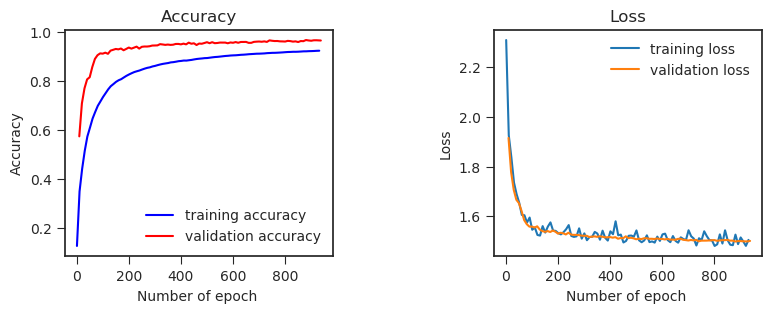

In [104]:
debug=True
history_train=ml_utils.load_data_tensorboard(FLAGS.model_dir)
history_eval=ml_utils.load_data_tensorboard(FLAGS.model_dir+'/eval')
if debug:
    print('\n')
    for file in glob.glob(FLAGS.model_dir+'*'):
        print(re.findall(r'[^\\/]+|[\\/]',file)[-1])
    print('\n')
    print(history_train.keys())
    print(history_eval.keys())
    print('number of entry for train:', len(history_train['loss'][0]))
    print('number of entry for eval:', len(history_eval['loss'][0]))
print('\n\n\n')
ml_utils.plot_acc_loss(history_train['loss'][0],history_train['loss'][1],
                       history_train['accuracy_1'][0],history_train['accuracy_1'][1],
                       history_eval['loss'][0],history_eval['loss'][1],
                       history_eval['accuracy'][0],history_eval['accuracy'][1])

### Train the model on locally using gcloud

In [109]:
%%bash
# Use Cloud Machine Learning Engine to train the model in local file system
gcloud ml-engine local train \
   --module-name=trainer.task \
   --package-path=${PWD}/src/${MODEL_NAME}/trainer \
   -- \
   --epoch=2 \
   --step_per_epoch=468 \
   --input_test_tfrecords=${PWD}/'data/mnist/tfrecords_image_test/*' \
   --input_train_tfrecords=${PWD}/'data/mnist/tfrecords_image_train/*' \
   --model_dir=${PWD}/'results/Models/Mnist/tf_1_12/estimator/ckpt/' \
   --saved_dir=${PWD}/'results/Models/Mnist/tf_1_12/estimator/pt/' 

exporter <tensorflow.python.estimator.exporter.LatestExporter object at 0x1c32505668>
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 

INFO:tensorflow:TF_CONFIG environment variable: {'environment': 'cloud', 'cluster': {}, 'job': {'args': ['--epoch=2', '--step_per_epoch=468', '--input_test_tfrecords=/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP/data/mnist/tfrecords_image_test/*', '--input_train_tfrecords=/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP/data/mnist/tfrecords_image_train/*', '--model_dir=/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP/results/Models/Mnist/tf_1_12/estimator/ckpt/', '--saved_dir=/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP/results/Models/Mnist/tf_1_12/estimator/pt/'], 'job_name': 'trainer.task'}, 'task': {}}
INFO:tensorflow:Initializing RunConfig with distribution strategies.
INFO:tensorflow:RunConfig initialized for Distribute Coordinator with INDEPENDENT_WORKER mode
INFO:

DEBUG:tensorflow:Opening a record reader pointing at results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553686740.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Loading events from results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553686740.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Cannot read more events: Read less bytes than requested
DEBUG:tensorflow:No more events in results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553686740.Fabien-Tarrades-MacBook-Pro.local
INFO:tensorflow:No path found after results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553686740.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Opening a record reader pointing at results/Models/Mnist/tf_1_12/estimator/ckpt//eval/events.out.tfevents.1553686744.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Loading events from results/Models/Mnist/tf_1_12/estimator/ckpt//eval/events.out.tfevents.1553686744.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tens

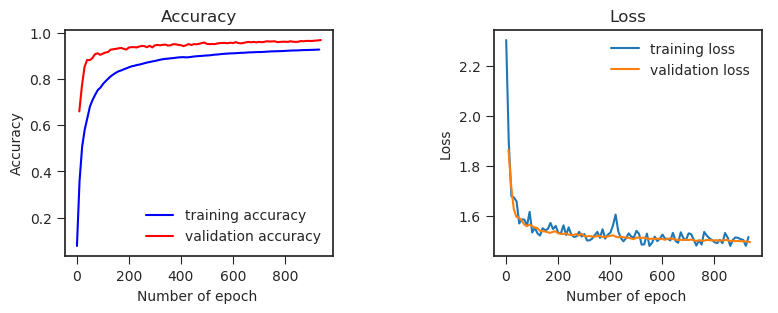

In [110]:
debug=True
history_train=ml_utils.load_data_tensorboard(FLAGS.model_dir)
history_eval=ml_utils.load_data_tensorboard(FLAGS.model_dir+'/eval')
if debug:
    print('\n')
    for file in glob.glob(FLAGS.model_dir+'*'):
        print(re.findall(r'[^\\/]+|[\\/]',file)[-1])
    print('\n')
    print(history_train.keys())
    print(history_eval.keys())
    print('number of entry for train:', len(history_train['loss'][0]))
    print('number of entry for eval:', len(history_eval['loss'][0]))
print('\n\n\n')
ml_utils.plot_acc_loss(history_train['loss'][0],history_train['loss'][1],
                       history_train['accuracy_1'][0],history_train['accuracy_1'][1],
                       history_eval['loss'][0],history_eval['loss'][1],
                       history_eval['accuracy'][0],history_eval['accuracy'][1])

### Train the model on GCP using gcloud

In [630]:
!gsutil ls gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/

gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-1.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-10.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-2.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-3.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-4.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-5.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-6.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-7.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-8.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-9.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/tfrecord_image_test/
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/tfrecords_image_test/


In [111]:
!pwd

/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP


In [653]:
%%bash
echo "gs://${PROJECT}/mnist/tfrecords/image_test/"

gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/


In [658]:
%%bash
# Clear Cloud Storage bucket and copy the tfrecords files to Cloud Storage bucket
echo $BUCKET
gsutil -m rm -rf "gs://${BUCKET}/mnist/tfrecords/image_test/"
gsutil -m rm -rf "gs://${BUCKET}/mnist/tfrecords/image_train/"
gsutil -m cp "${PWD}/data/mnist/tfrecords_image_test/*" "gs://${BUCKET}/mnist/tfrecords/image_test/"
gsutil -m cp "${PWD}/data/mnist/tfrecords_image_train/*" "gs://${BUCKET}/mnist/tfrecords/image_train/"

ml-productive-pipeline-53122


Removing gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-1.tfrecords#1553517828053883...
Removing gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-10.tfrecords#1553517828015615...
Removing gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-2.tfrecords#1553517827285785...
Removing gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-3.tfrecords#1553517827539125...
Removing gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-4.tfrecords#1553517828118894...
Removing gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-5.tfrecords#1553517827486017...
Removing gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-6.tfrecords#1553517827901783...
Removing gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-7.tfrecords#1553517828044041...
Removing gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-8.tfrecords#1553517827140683...
Removing gs://ml-productive-pipeline

In [696]:
%%bash
OUTDIR="gs://${BUCKET}/${MODEL_NAME}/${TRAINING_DIR}"
JOBNAME=${MODEL_NAME}_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
# Clear the Cloud Storage Bucket used for the training job
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
   --region=$REGION \
   --module-name=trainer.task \
   --package-path=${PWD}/src/${MODEL_NAME}/trainer \
   --job-dir=$OUTDIR \
   --staging-bucket="gs://$BUCKET" \
   --scale-tier=$TIER \
   --runtime-version=$TFVERSION \
   --python-version='3.5' \
   --labels=$RESOURCE_LABELS \
   -- \
   --epoch=2 \
   --step_per_epoch=468 \
   --input_test_tfrecords= "gs://${BUCKET}/mnist/tfrecords/image_test/*" \
   --input_train_tfrecords="gs://${BUCKET}/mnist/tfrecords/image_train/*" \
   --model_dir=$OUTDIR \
   --saved_dir=$OUTDIR   

gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained us-central1 model_mnist_v1_190325_152158
jobId: model_mnist_v1_190325_152158
state: QUEUED


CommandException: 1 files/objects could not be removed.
Job [model_mnist_v1_190325_152158] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ml-engine jobs describe model_mnist_v1_190325_152158

or continue streaming the logs with the command

  $ gcloud ml-engine jobs stream-logs model_mnist_v1_190325_152158


In [697]:
! gcloud ml-engine jobs stream-logs model_mnist_v1_190325_152158

INFO	2019-03-25 16:22:04 +0100	service		Validating job requirements...
INFO	2019-03-25 16:22:04 +0100	service		Job creation request has been successfully validated.
INFO	2019-03-25 16:22:05 +0100	service		Job model_mnist_v1_190325_152158 is queued.
INFO	2019-03-25 16:22:05 +0100	service		Waiting for job to be provisioned.
INFO	2019-03-25 16:22:08 +0100	service		Waiting for training program to start.
INFO	2019-03-25 16:23:44 +0100	master-replica-0		Running task with arguments: --cluster={"master": ["127.0.0.1:2222"]} --task={"type": "master", "index": 0} --job={  "package_uris": ["gs://ml-productive-pipeline-53122/model_mnist_v1_190325_152158/c22fca2b0adcf8de1bb4a11353a9ac9cc2f655f4d527462ea4346efc2e3e7a11/model_mnist_v1-0.1.tar.gz"],  "python_module": "trainer.task",  "args": ["--epoch\u003d2", "--step_per_epoch\u003d468", "--input_test_tfrecords\u003d", "gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/*", "--input_train_tfrecords\u003dgs://ml-productive-pipeline-53122/mni

INFO	2019-03-25 16:24:28 +0100	master-replica-0		TF_CONFIG environment variable: {'task': {'cloud': 'qe913eccfb8ab063b-ml', 'index': 0, 'type': 'master'}, 'cluster': {'master': ['127.0.0.1:2222']}, 'environment': 'cloud', 'job': {'runtime_version': '1.12', 'python_module': 'trainer.task', 'package_uris': ['gs://ml-productive-pipeline-53122/model_mnist_v1_190325_152158/c22fca2b0adcf8de1bb4a11353a9ac9cc2f655f4d527462ea4346efc2e3e7a11/model_mnist_v1-0.1.tar.gz'], 'python_version': '3.5', 'job_dir': 'gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained', 'region': 'us-central1', 'run_on_raw_vm': True, 'args': ['--epoch=2', '--step_per_epoch=468', '--input_test_tfrecords=', 'gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/*', '--input_train_tfrecords=gs://ml-productive-pipeline-53122/mnist/tfrecords/image_train/*', '--model_dir=gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained', '--saved_dir=gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained',

INFO	2019-03-25 16:25:09 +0100	master-replica-0		Assets added to graph.
INFO	2019-03-25 16:25:09 +0100	master-replica-0		No assets to write.
INFO	2019-03-25 16:25:15 +0100	master-replica-0		SavedModel written to: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/export/exporter/temp-b'1553527507'/saved_model.pb
INFO	2019-03-25 16:25:19 +0100	master-replica-0		Saving checkpoints for 40 into gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt.
INFO	2019-03-25 16:25:26 +0100	master-replica-0		input_dataset_fn: EVAL, eval
INFO	2019-03-25 16:25:26 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:25:26 +0100	master-replica-0		Done calling model_fn.
INFO	2019-03-25 16:25:26 +0100	master-replica-0		Starting evaluation at 2019-03-25-15:25:26
INFO	2019-03-25 16:25:26 +0100	master-replica-0		Graph was finalized.
INFO	2019-03-25 16:25:26 +0100	master-replica-0		Restoring parameters from gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/mo

INFO	2019-03-25 16:26:26 +0100	master-replica-0		Signatures INCLUDED in export for Regress: None
INFO	2019-03-25 16:26:26 +0100	master-replica-0		Restoring parameters from gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-100
INFO	2019-03-25 16:26:26 +0100	master-replica-0		Assets added to graph.
INFO	2019-03-25 16:26:26 +0100	master-replica-0		No assets to write.
INFO	2019-03-25 16:26:31 +0100	master-replica-0		SavedModel written to: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/export/exporter/temp-b'1553527585'/saved_model.pb
INFO	2019-03-25 16:26:34 +0100	master-replica-0		global_step/sec: 1.00519
INFO	2019-03-25 16:26:34 +0100	master-replica-0		loss = 0.31793758, step = 100 (99.484 sec)
INFO	2019-03-25 16:26:34 +0100	master-replica-0		Saving checkpoints for 120 into gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt.
INFO	2019-03-25 16:26:41 +0100	master-replica-0		input_dataset_fn: EVAL, eval
INFO	2019-03-25 16:26:41

INFO	2019-03-25 16:27:40 +0100	master-replica-0		Signatures INCLUDED in export for Eval: None
INFO	2019-03-25 16:27:40 +0100	master-replica-0		Signatures INCLUDED in export for Predict: ['serving_default']
INFO	2019-03-25 16:27:40 +0100	master-replica-0		Signatures INCLUDED in export for Classify: None
INFO	2019-03-25 16:27:40 +0100	master-replica-0		Signatures INCLUDED in export for Train: None
INFO	2019-03-25 16:27:40 +0100	master-replica-0		Signatures INCLUDED in export for Regress: None
INFO	2019-03-25 16:27:40 +0100	master-replica-0		Restoring parameters from gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-180
INFO	2019-03-25 16:27:40 +0100	master-replica-0		Assets added to graph.
INFO	2019-03-25 16:27:40 +0100	master-replica-0		No assets to write.
INFO	2019-03-25 16:27:45 +0100	master-replica-0		SavedModel written to: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/export/exporter/temp-b'1553527658'/saved_model.pb
INFO	2019-03-25 16:27:48 

INFO	2019-03-25 16:28:46 +0100	master-replica-0		Starting evaluation at 2019-03-25-15:28:46
INFO	2019-03-25 16:28:46 +0100	master-replica-0		Graph was finalized.
INFO	2019-03-25 16:28:46 +0100	master-replica-0		Restoring parameters from gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-260
INFO	2019-03-25 16:28:47 +0100	master-replica-0		Running local_init_op.
INFO	2019-03-25 16:28:47 +0100	master-replica-0		Done running local_init_op.
INFO	2019-03-25 16:28:47 +0100	master-replica-0		Finished evaluation at 2019-03-25-15:28:47
INFO	2019-03-25 16:28:47 +0100	master-replica-0		Saving dict for global step 260: accuracy = 0.0, global_step = 260, loss = 0.0
INFO	2019-03-25 16:28:47 +0100	master-replica-0		Saving 'checkpoint_path' summary for global step 260: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-260
INFO	2019-03-25 16:28:48 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:28:48 +0100	master-replica-0		Done calling model_

INFO	2019-03-25 16:29:54 +0100	master-replica-0		Done running local_init_op.
INFO	2019-03-25 16:29:54 +0100	master-replica-0		Finished evaluation at 2019-03-25-15:29:54
INFO	2019-03-25 16:29:54 +0100	master-replica-0		Saving dict for global step 340: accuracy = 0.0, global_step = 340, loss = 0.0
INFO	2019-03-25 16:29:54 +0100	master-replica-0		Saving 'checkpoint_path' summary for global step 340: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-340
INFO	2019-03-25 16:29:55 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:29:55 +0100	master-replica-0		Done calling model_fn.
INFO	2019-03-25 16:29:55 +0100	master-replica-0		Signatures INCLUDED in export for Eval: None
INFO	2019-03-25 16:29:55 +0100	master-replica-0		Signatures INCLUDED in export for Predict: ['serving_default']
INFO	2019-03-25 16:29:55 +0100	master-replica-0		Signatures INCLUDED in export for Classify: None
INFO	2019-03-25 16:29:55 +0100	master-replica-0		Signatures INCLUDED in export 

INFO	2019-03-25 16:30:48 +0100	master-replica-0		SavedModel written to: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/export/exporter/temp-b'1553527844'/saved_model.pb
INFO	2019-03-25 16:30:51 +0100	master-replica-0		global_step/sec: 1.22815
INFO	2019-03-25 16:30:51 +0100	master-replica-0		loss = 0.047065996, step = 400 (81.423 sec)
INFO	2019-03-25 16:30:51 +0100	master-replica-0		Saving checkpoints for 420 into gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt.
INFO	2019-03-25 16:30:57 +0100	master-replica-0		input_dataset_fn: EVAL, eval
INFO	2019-03-25 16:30:57 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:30:57 +0100	master-replica-0		Done calling model_fn.
INFO	2019-03-25 16:30:57 +0100	master-replica-0		Starting evaluation at 2019-03-25-15:30:57
INFO	2019-03-25 16:30:58 +0100	master-replica-0		Graph was finalized.
INFO	2019-03-25 16:30:58 +0100	master-replica-0		Restoring parameters from gs://ml-productive-pipeline-53122/mode

INFO	2019-03-25 16:31:54 +0100	master-replica-0		Saving checkpoints for 500 into gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt.
INFO	2019-03-25 16:32:00 +0100	master-replica-0		input_dataset_fn: EVAL, eval
INFO	2019-03-25 16:32:01 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:32:01 +0100	master-replica-0		Done calling model_fn.
INFO	2019-03-25 16:32:01 +0100	master-replica-0		Starting evaluation at 2019-03-25-15:32:01
INFO	2019-03-25 16:32:01 +0100	master-replica-0		Graph was finalized.
INFO	2019-03-25 16:32:01 +0100	master-replica-0		Restoring parameters from gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-500
INFO	2019-03-25 16:32:01 +0100	master-replica-0		Running local_init_op.
INFO	2019-03-25 16:32:01 +0100	master-replica-0		Done running local_init_op.
INFO	2019-03-25 16:32:02 +0100	master-replica-0		Finished evaluation at 2019-03-25-15:32:02
INFO	2019-03-25 16:32:02 +0100	master-replica-0		Saving dict for global

INFO	2019-03-25 16:32:49 +0100	master-replica-0		No assets to write.
INFO	2019-03-25 16:32:53 +0100	master-replica-0		SavedModel written to: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/export/exporter/temp-b'1553527968'/saved_model.pb
INFO	2019-03-25 16:32:56 +0100	master-replica-0		Saving checkpoints for 580 into gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt.
INFO	2019-03-25 16:33:08 +0100	master-replica-0		SavedModel written to: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/export/exporter/temp-b'1553527984'/saved_model.pb
INFO	2019-03-25 16:33:11 +0100	master-replica-0		Saving checkpoints for 600 into gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt.
INFO	2019-03-25 16:33:17 +0100	master-replica-0		input_dataset_fn: EVAL, eval
INFO	2019-03-25 16:33:17 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:33:17 +0100	master-replica-0		Done calling model_fn.
INFO	2019-03-25 16:33:17 +0100	m

INFO	2019-03-25 16:34:02 +0100	master-replica-0		Saving dict for global step 660: accuracy = 0.0, global_step = 660, loss = 0.0
INFO	2019-03-25 16:34:05 +0100	master-replica-0		Saving 'checkpoint_path' summary for global step 660: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-660
INFO	2019-03-25 16:34:06 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:34:06 +0100	master-replica-0		Done calling model_fn.
INFO	2019-03-25 16:34:06 +0100	master-replica-0		Signatures INCLUDED in export for Eval: None
INFO	2019-03-25 16:34:06 +0100	master-replica-0		Signatures INCLUDED in export for Predict: ['serving_default']
INFO	2019-03-25 16:34:06 +0100	master-replica-0		Signatures INCLUDED in export for Classify: None
INFO	2019-03-25 16:34:06 +0100	master-replica-0		Signatures INCLUDED in export for Train: None
INFO	2019-03-25 16:34:06 +0100	master-replica-0		Signatures INCLUDED in export for Regress: None
INFO	2019-03-25 16:34:06 +0100	master-replica-0		Restori

INFO	2019-03-25 16:35:04 +0100	master-replica-0		Saving dict for global step 740: accuracy = 0.0, global_step = 740, loss = 0.0
INFO	2019-03-25 16:35:04 +0100	master-replica-0		Saving 'checkpoint_path' summary for global step 740: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-740
INFO	2019-03-25 16:35:05 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:35:05 +0100	master-replica-0		Done calling model_fn.
INFO	2019-03-25 16:35:05 +0100	master-replica-0		Signatures INCLUDED in export for Eval: None
INFO	2019-03-25 16:35:05 +0100	master-replica-0		Signatures INCLUDED in export for Predict: ['serving_default']
INFO	2019-03-25 16:35:05 +0100	master-replica-0		Signatures INCLUDED in export for Classify: None
INFO	2019-03-25 16:35:05 +0100	master-replica-0		Signatures INCLUDED in export for Train: None
INFO	2019-03-25 16:35:05 +0100	master-replica-0		Signatures INCLUDED in export for Regress: None
INFO	2019-03-25 16:35:05 +0100	master-replica-0		Restori

INFO	2019-03-25 16:36:02 +0100	master-replica-0		Running local_init_op.
INFO	2019-03-25 16:36:02 +0100	master-replica-0		Done running local_init_op.
INFO	2019-03-25 16:36:02 +0100	master-replica-0		Finished evaluation at 2019-03-25-15:36:02
INFO	2019-03-25 16:36:02 +0100	master-replica-0		Saving dict for global step 820: accuracy = 0.0, global_step = 820, loss = 0.0
INFO	2019-03-25 16:36:02 +0100	master-replica-0		Saving 'checkpoint_path' summary for global step 820: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-820
INFO	2019-03-25 16:36:03 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:36:03 +0100	master-replica-0		Done calling model_fn.
INFO	2019-03-25 16:36:03 +0100	master-replica-0		Signatures INCLUDED in export for Eval: None
INFO	2019-03-25 16:36:03 +0100	master-replica-0		Signatures INCLUDED in export for Predict: ['serving_default']
INFO	2019-03-25 16:36:03 +0100	master-replica-0		Signatures INCLUDED in export for Classify: None
INFO	20

INFO	2019-03-25 16:37:03 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:37:03 +0100	master-replica-0		Done calling model_fn.
INFO	2019-03-25 16:37:03 +0100	master-replica-0		Signatures INCLUDED in export for Eval: None
INFO	2019-03-25 16:37:03 +0100	master-replica-0		Signatures INCLUDED in export for Predict: ['serving_default']
INFO	2019-03-25 16:37:03 +0100	master-replica-0		Signatures INCLUDED in export for Classify: None
INFO	2019-03-25 16:37:03 +0100	master-replica-0		Signatures INCLUDED in export for Train: None
INFO	2019-03-25 16:37:03 +0100	master-replica-0		Signatures INCLUDED in export for Regress: None
INFO	2019-03-25 16:37:03 +0100	master-replica-0		Restoring parameters from gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-900
INFO	2019-03-25 16:37:03 +0100	master-replica-0		Assets added to graph.
INFO	2019-03-25 16:37:03 +0100	master-replica-0		No assets to write.
INFO	2019-03-25 16:37:08 +0100	master-replica-0		SavedModel written to:

INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-

## Visualization

In [ ]:
#for e in tf.train.summary_iterator('/tmp/mnist_convnet_model/events.out.tfevents.1553025053.Fabien-Tarrades-MacBook-Pro.local'):
for e in tf.train.summary_iterator('results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553024123.Fabien-Tarrades-MacBook-Pro.local'):
    for v in e.summary.value:
        #if v.tag == 'accuracy':
        #print(v.simple_value)
        print(v)

In [736]:
from tensorboard.backend.event_processing import event_accumulator
import numpy as np

def load_data_tensorboard(path):
    event_acc = event_accumulator.EventAccumulator(path)
    event_acc.Reload()
    data = {}
    
    for tag in sorted(event_acc.Tags()["scalars"]):
        x, y = [], []
        for scalar_event in event_acc.Scalars(tag):
            x.append(scalar_event.step)
            y.append(scalar_event.value)
        data[tag] = (np.asarray(x), np.asarray(y))
    return data

In [739]:
#history_eval=load_data_tensorboard(FLAGS.model_dir+'/eval')
history_train=load_data_tensorboard(FLAGS.model_dir)

DEBUG:tensorflow:Opening a record reader pointing at results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553604823.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Loading events from results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553604823.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Cannot read more events: Read less bytes than requested
DEBUG:tensorflow:No more events in results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553604823.Fabien-Tarrades-MacBook-Pro.local
INFO:tensorflow:No path found after results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553604823.Fabien-Tarrades-MacBook-Pro.local


In [740]:
history_eval.keys(), history_train.keys()

(dict_keys(['accuracy', 'loss']), dict_keys(['global_step/sec', 'loss_1']))

In [574]:
len(history_train['accuracy_1'][1]), len(history_eval['accuracy'][1]), len(history_train['global_step/sec'][1])

(100, 100, 19)

In [575]:
history_eval['accuracy'][0]

array([  10,   20,   30,   40,   50,   60,   70,   80,   90,  100,  110,
        120,  130,  140,  150,  160,  170,  180,  190,  200,  210,  220,
        230,  240,  250,  260,  270,  280,  290,  300,  310,  320,  330,
        340,  350,  360,  370,  380,  390,  400,  410,  420,  430,  440,
        450,  460,  470,  480,  490,  500,  510,  520,  530,  540,  550,
        560,  570,  580,  590,  600,  610,  620,  630,  640,  650,  660,
        670,  680,  690,  700,  710,  720,  730,  740,  750,  760,  770,
        780,  790,  800,  810,  820,  830,  840,  850,  860,  870,  880,
        890,  900,  910,  920,  930,  940,  950,  960,  970,  980,  990,
       1000])

In [741]:
history_train['accuracy_1'][0]

KeyError: 'accuracy_1'

Loss:
  - loss [training dataset]: 1.526
  - loss [validation dataset: 1.496

Accuracy:
  - accuracy [training dataset]: 92.73%
  - accuracy [validation dataset: 96.68%


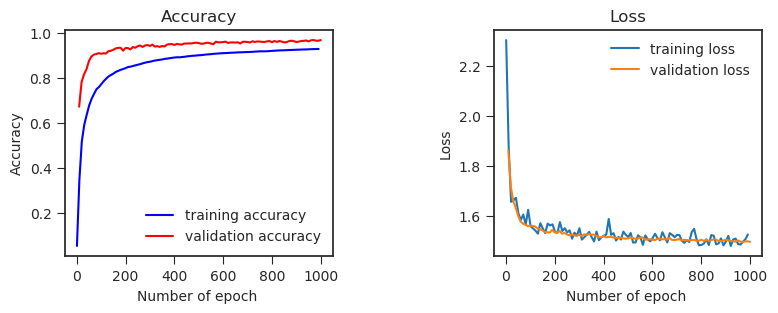

In [577]:
# plot the training loss and accuracy
fig = plt.figure(figsize=(9, 3), dpi=100)
plt.subplots_adjust(wspace=0.6)
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
ax1.plot(history_train['accuracy_1'][0], history_train['accuracy_1'][1], 'b', label='training accuracy')
ax1.plot(history_eval['accuracy'][0], history_eval['accuracy'][1], 'r', label='validation accuracy');
ax1.set_title('Accuracy')
ax1.set_xlabel("Number of epoch ")
ax1.set_ylabel("Accuracy")
ax1.legend(loc="best")

ax2.plot(history_train['loss'][0], history_train['loss'][1], label="training loss")
ax2.plot(history_eval['loss'][0], history_eval['loss'][1], label="validation loss")
ax2.set_title("Loss")
ax2.set_xlabel("Number of epoch ")
ax2.set_ylabel("Loss")
ax2.legend(loc="best");

print('Loss:')
print('  - loss [training dataset]: {0:.3f}'.format(history_train['loss'][1][-1]))
print('  - loss [validation dataset: {0:.3f}'.format(history_eval['loss'][1][-1]))
print('')
print('Accuracy:')
print('  - accuracy [training dataset]: {:.2f}%'.format(100 * history_train['accuracy_1'][1][-1]))
print('  - accuracy [validation dataset: {:.2f}%'.format(100 * history_eval['accuracy'][1][-1]))

### Check the output created during the training
https://medium.com/@prasadpal107/saving-freezing-optimizing-for-inference-restoring-of-tensorflow-models-b4146deb21b5  
- creating a keras model will create the **keras** folder 
- **checkpoint**, text file that contain all checkpoint information, like model ckpt file name and path
- **model.ckpt-xxx.meta** and **model.ckpt-xxx.data-yyyyy-of-zzzzz** and **model.ckpt-xxx.index** file created for each model  
  .ckpt-xxx.meta contains the complete graph. It includes GraphDef, SaverDef, and so on  
  .ckpt-xxx.data contains the values of variables(weights, biases, placeholders, gradients, hyper-parameters etc)   
  .ckpt-xxx.index is a table where each key is the name of a tensor and its value is a serialized BundleEntryProto 
- **graph.pbtxt** holds a network of nodes, each representing one operation, connected to each other as inputs and outputs (graph structure)
- **events.out.tfevents.xxxxxxxxxx** which contain information that TensorBoard uses to create visualizations

Meta files holds ,more than just the structure of the graph like MetaInfoDef , GraphDef SaverDef , CollectionDef . Whereas .pbtxt files holds only the structure of the graph.

In [100]:
for file in glob.glob(FLAGS.model_dir+'*'):
    print(re.findall(r'[^\\/]+|[\\/]',file)[-1])

keras
checkpoint
model.ckpt-940.data-00000-of-00001
model.ckpt-1000.data-00000-of-00001
model.ckpt-920.meta
model.ckpt-940.meta
model.ckpt-1000.meta
model.ckpt-960.meta
events.out.tfevents.1552739145.Fabien-Tarrades-MacBook-Pro.local
graph.pbtxt
model.ckpt-980.meta
model.ckpt-960.data-00000-of-00001
model.ckpt-920.index
model.ckpt-920.data-00000-of-00001
eval
model.ckpt-980.data-00000-of-00001
export
model.ckpt-960.index
model.ckpt-980.index
model.ckpt-940.index
model.ckpt-1000.index


### TensorBoard

In [39]:
print('Tensorflow logs will be saved here:\n',FLAGS.model_dir)

Tensorflow logs will be saved here:
 results/Models/Mnist/tf_1_12/estimator/ckpt/


In [243]:
for file in glob.glob(FLAGS.model_dir+'*events.out.tfevents.*'):
    print(re.findall(r'[^\\/]+|[\\/]',file)[-1])

events.out.tfevents.1553024123.Fabien-Tarrades-MacBook-Pro.local


In [228]:
tensorboard_command='tensorboard --logdir "'+FLAGS.model_dir+'"'

In [42]:
print('In a separate shell with the same env activated (need Tensoflow and TensorBoard)')
print('  copy and pate the command below without ">>":')
print('  >>',tensorboard_command)


In a separate shell with the same env activated (need Tensoflow and TensorBoard)
  copy and pate the command below without ">>":
  >> tensorboard --logdir "results/Models/Mnist/tf_1_12/estimator/ckpt/"


### Looking at the output of the TimeHistory

In [ ]:
total_time = sum(time_hist.times)
print(f"total time with the current strategy: {total_time} seconds")

In [ ]:
avg_time_per_batch = np.mean(time_hist.times)
print(f"{BATCH_SIZE/avg_time_per_batch} images/second")

## Accuracy and losses

### Training dataset

In [ ]:
score=estimator_train_model.evaluate(input_fn=lambda:mnist_v1.input_mnist_tfrecord_dataset_fn(glob.glob(path_train_tfrecords+'/train*.tfrecords'),
                                                                                              FLAGS,
                                                                                              mode=tf.estimator.ModeKeys.TRAIN,
                                                                                              batch_size=FLAGS.batch_size),
                                     steps=1)

In [ ]:
# print test accuracy
print('Loss:')
print('  - loss [training dataset]: {0:.3f}'.format(score['loss']))
print('')
print('Accuracy:')
print('  - accuracy [training dataset]: {:.2f}%'.format(100*score['accuracy']))
print('')
print('Number of steps:')
print('  - number of steps [training dataset]: {}'.format(score['global_step']))

### Testing dataset

In [ ]:
score=estimator_train_model.evaluate(input_fn=lambda:mnist_v1.input_mnist_tfrecord_dataset_fn(glob.glob(path_test_tfrecords+'/test*.tfrecords'),
                                                                                              FLAGS,
                                                                                              mode=tf.estimator.ModeKeys.EVAL,
                                                                                              batch_size=FLAGS.batch_size),
                                     steps=1)

In [ ]:
# print test accuracy
print('Loss:')
print('  - loss [testing dataset]: {0:.3f}'.format(score['loss']))
print('')
print('Accuracy:')
print('  - accuracy [testing dataset]: {:.2f}%'.format(100*score['accuracy']))
print('')
print('Number of steps:')
print('  - number of steps [testing dataset]: {}'.format(score['global_step']))

## Test

In [ ]:
# Rebuild the model
predictions = model_fn(features, labels, tf.estimator.ModeKeys.EVAL).predictions

# Manually load the latest checkpoint
saver = tf.train.Saver()
with tf.Session() as sess:
    ckpt = tf.train.get_checkpoint_state('/my/directory')
    saver.restore(sess, ckpt.model_checkpoint_path)

    # Loop through the batches and store predictions and labels
    prediction_values = []
    label_values = []
    while True:
        try:
            preds, lbls = sess.run([predictions, labels])
            prediction_values += preds
            label_values += lbls
        except tf.errors.OutOfRangeError:
            break
    # store prediction_values and label_values somewhere

## Prediction 

### Method 1

In [ ]:
testing_dataset = mnist_v1.input_mnist_tfrecord_dataset_fn(sorted(glob.glob(path_test_tfrecords+'/test*.tfrecords'), key=os.path.getmtime),
                                                           FLAGS,
                                                           mode=tf.estimator.ModeKeys.EVAL)

In [ ]:
iterator = testing_dataset.make_one_shot_iterator()
# next_element
features, labels = iterator.get_next()

In [ ]:
n=0

n_iter=10
with tf.Session() as sess:
    while True:
        try:
            start_time = time.clock()
            x,y = sess.run([features, labels])
            print('iteration n:', n, 'execution time:', time.clock() - start_time, 'seconds')
            print(x.shape)
            print(y.shape)
            print('first label of the batch',np.argmax(y[0]),'\n')
            n+=1
            if n>=n_iter:
                print('number of iteration reached')
                break
        except tf.errors.OutOfRangeError:
            print('tf.errors.OutOfRangeError')
            break

In [ ]:
predictions=list(estimator_train_model.predict(input_fn=lambda:mnist_v1.input_mnist_tfrecord_dataset_fn(sorted(glob.glob(path_test_tfrecords+'/test*.tfrecords'), key=os.path.getmtime),
                                                                                                  FLAGS,
                                                                                                  mode=tf.estimator.ModeKeys.PREDICT)))

In [ ]:
len(predictions), len(x_test)

In [ ]:
output_layer=model_opt_tf.output_names[0]

In [ ]:
for i in range(10):
    prediction_array = predictions[i][output_layer]
    predicted_label = np.argmax(prediction_array)
    print('Actual label:', y_test[i])
    print("Predicted label: ", predicted_label)

### Method 2

In [ ]:
preds_iter=estimator_train_model.predict(input_fn=lambda:mnist_v1.input_mnist_tfrecord_dataset_fn(sorted(glob.glob(path_test_tfrecords+'/test*.tfrecords'), key=os.path.getmtime),
                                                                                                  FLAGS,
                                                                                                  mode=tf.estimator.ModeKeys.EVAL,
                                                                                                  batch_size=len(x_test)))

In [ ]:
i=0
for pred in list(itertools.islice(preds_iter, 5)):
    prediction_array = pred['dense_2']
    predicted_label = np.argmax(prediction_array)
    print(prediction_array)
    print(i)
    if i==0:
        print('--> ',pred.keys())
    print()
    print('Actual label:', y_test[i])
    print("Predicted label: ", predicted_label)
    i+=1

### Keras's model checks

In [ ]:
model_opt_tf.summary()

In [ ]:
model_opt_tf.input_names

In [ ]:
model_opt_tf.output_names

In [ ]:
output_layer=model_opt_tf.output_names[0]

### Estimator's model checks

In [ ]:
estimator_train_model.get_variable_names()

In [ ]:
estimator_train_model.get_variable_value(estimator_train_model.get_variable_names()[0]).shape

In [ ]:
estimator_train_model.get_variable_value(estimator_train_model.get_variable_names()[1]).shape

In [ ]:
estimator_train_model.latest_checkpoint()

## Model serving using Keras, tf.estimator and tf.data.dataset

In [ ]:
for file in glob.glob(FLAGS.saved_dir+'*'):
    print(re.findall(r'[^\\/]+|[\\/]',file)[-1])

In [ ]:
shutil.rmtree(FLAGS.saved_dir, ignore_errors=True)

In [ ]:
model_opt_tf.input_names

In [ ]:
def serving_input_receiver_fn():
    """Serving input_fn that builds features from placeholders#

    Returns
    -------
    tf.estimator.export.ServingInputReceiver
    """
    input_images = tf.placeholder(tf.float32, [None, 784])
    features = {'dense_2_input' : input_images} # this is the dict that is then passed as "features" parameter to your model_fn
    receiver_tensors = {'dense_2_input': input_images} # As far as I understand this is needed to map the input to a name you can retrieve later
   
    return tf.estimator.export.ServingInputReceiver(features, receiver_tensors)

In [ ]:
if not os.path.exists(FLAGS.saved_dir):
    os.makedirs(FLAGS.saved_dir)

In [ ]:
# Option 2: Only export predict mode
estimator_train_model.export_saved_model(os.path.abspath(FLAGS.saved_dir), 
                                         serving_input_receiver_fn=serving_input_receiver_fn)

In [495]:
for file in glob.glob(FLAGS.saved_dir+'*'):
    print(re.findall(r'[^\\/]+|[\\/]',file)[-1])

**Update the model id in the path below with the correct one from above i.e'1549040172'**

In [504]:
model_tag='1549054852'
os.environ['MODEL_FOR_SERVING']='results/Models/Mnist/tf_1_12/estimator/ckpt/export/exporter/1553112141'#FLAGS.saved_dir+model_tag+'/'

In [502]:
!ls results/Models/Mnist/tf_1_12/estimator/ckpt/export/exporter/1553112141

saved_model.pb variables


In [ ]:
# replace the folder name below with the one from above i.e '1549040172'
for file in glob.glob(FLAGS.saved_dir+model_tag+'/*'):
    print(re.findall(r'[^\\/]+|[\\/]',file)[-1])

## Check the saved model before serving 

In [493]:
tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY,

('serving_default',)

In [505]:
! saved_model_cli show --dir $MODEL_FOR_SERVING --tag serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['dense_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 784)
      name: Placeholder:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['classes'] tensor_info:
      dtype: DT_INT64
      shape: (-1)
      name: ArgMax:0
  outputs['probabilities'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 10)
      name: Softmax:0
Method name is: tensorflow/serving/predict


## Use Cloud ML Engine

### Checking gcloud installation (SDK)

In [ ]:
os.environ['CLOUDSDK_PYTHON']='/Users/tarrade/anaconda3/bin/python'

### Create a input json file and string

Input needed to get prediction using ml-engine an option --json-instances: 'dense_2_input' for each new entry

In [ ]:
input_prediction=x_test[0:3]

In [ ]:
data = input_prediction.tolist()
json_file = "../data/input_predict_gcloud.json" 

with codecs.open(json_file, 'w', encoding='utf-8') as f:
    for el in data:
        instance = {'dense_2_input': el}
        json.dump(instance, f , sort_keys=True)
        f.write("\n")

Input needed to get prediction using ml-engine and cURL

In [ ]:
data = input_prediction.tolist()
json_file = "../data/input_predict_cURL.json" 

with codecs.open(json_file, 'w', encoding='utf-8') as f:
    tmp={}
    list_tmp=[]
    for el in data:
        tmp['dense_2_input']=el
        list_tmp.append(tmp)
    instance = {"instances": list_tmp}    
    json.dump(instance, f , sort_keys=True)
    f.write("\n")

In [ ]:
input_predict_request = json.dumps({"signature_name": "serving_default", "instances": input_prediction.tolist()})

display example

In [ ]:
def show(img, title):
    plt.figure()
    plt.imshow(img.reshape(28,28))
    plt.axis('off')
    plt.title('\n\n{}'.format(title), fontdict={'size': 16})

In [ ]:
for i in range(1):
    show(x_test[i],'Test dataset, true label: '+str(np.argmax(y_test[i])))

### Test the model inference using gcloud locally

In [ ]:
os.environ['CLOUDSDK_PYTHON']='/Users/tarrade/anaconda3/bin/python'

In [ ]:
!gcloud ml-engine local predict --model-dir $MODEL_FOR_SERVING --json-instances ../data/input_predict_gcloud.json 

### Deploy the model using Cloud ML Engine
- https://cloud.google.com/ml-engine/docs/v1/predict-request
- https://cloud.google.com/ml-engine/docs/tensorflow/online-predict#requesting_predictions

In [ ]:
os.environ['PROJECT']=subprocess.run('gcloud config list project --format "value(core.project)"', shell=True, check=True, stdout=subprocess.PIPE).stdout.decode().replace('\n', '')
os.environ['MODEL']='mnist'
os.environ['BUCKET']='gs://'+os.environ['PROJECT']
os.environ['VERSION']='v2'

In [ ]:
# gsutil need python 2.7
os.environ['CLOUDSDK_PYTHON']='/Users/tarrade/anaconda/bin/python'

In [ ]:
!gsutil cp -r $MODEL_FOR_SERVING $BUCKET/model_dir_tmp/

In [ ]:
!gcloud ml-engine models list

when creating the model for the first time

create a version and store the model

In [ ]:
!gcloud ml-engine versions create ${VERSION} \
--model ${MODEL} \
--origin=${BUCKET}/model_dir_tmp/1549054852 \
--runtime-version=1.12 \
--staging-bucket=${BUCKET}

#### Checking the list of model in ML-Engine

In [ ]:
!gcloud ml-engine models list

In [ ]:
 !gcloud ml-engine versions list --model mnist

#### Testing our model using ML-Engine

In [ ]:
!gcloud ml-engine predict --model=${MODEL} --version=${VERSION} --json-instances ../data/input_predict_gcloud.json

#### Testing using RESTful API 
- https://www.tensorflow.org/serving/api_rest  
RESTful API is an application program interface (API) that uses HTTP requests to GET, PUT, POST and DELETE data (Json)

Use cURL

In [ ]:
!curl https://ml.googleapis.com/v1/projects/${PROJECT}/models/${MODEL}/versions/${VERSION} \
-H "Authorization: Bearer $(gcloud auth print-access-token)" \

In [ ]:
!curl -X POST \
https://ml.googleapis.com/v1/projects/${PROJECT}/models/${MODEL}/versions/${VERSION}:predict \
-H "Content-Type: application/json" \
-H "Authorization: Bearer $(gcloud auth print-access-token)" \
-d @../data/input_predict_cURL.json 

Use python and requests

In [ ]:
url = 'https://ml.googleapis.com/v1/projects/'+os.environ['PROJECT']+'/models/'+os.environ['MODEL']+'/versions/'+os.environ['VERSION']+':predict'

headers = {
    'Content-Type': 'application/json',
    'Authorization':  'Bearer {}'.format(subprocess.run('gcloud auth print-access-token', shell=True, check=True, stdout=subprocess.PIPE).stdout.decode().replace('\n', ''))
}

json_response = requests.post(url=url, data=input_predict_request, headers=headers)
json.loads(json_response.text)

In [ ]:
predictions = json.loads(json_response.text)['predictions']

In [ ]:
for i in range(0,3):
    show(x_test[i], 'The model thought this was a {} , and it was actually a {}'.format(np.argmax(predictions[i]['dense_3']),np.argmax(y_test[i])))

#### Testing using gRPC API 
- https://cloud.google.com/endpoints/docs/grpc/about-grpc  
gRPC is a high performance, open-source universal RPC framework, developed by Google. In gRPC, a client application can directly call methods on a server application on a different machine as if it was a local object, making it easier to create distributed applications and services (Protobuf)

In [ ]:
# to do

## Debug Python environment

In [ ]:
!python -c "import tensorflow as tf; print(tf.GIT_VERSION, tf.VERSION)"

In [ ]:
!conda list

In [ ]:
## Reload the model and make evaluation using Keras

In [ ]:
reload_model_opt_keras=tf.keras.models.load_model(FLAGS.model_dir_keras+'keras_model.h5')

In [ ]:
score = reload_model_opt_keras.evaluate(x_train, 
                                        y_train, 
                                        verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

In [ ]:
### Evaluate the model using Keras and tf.data.dataset

In [ ]:
score = model_opt_keras.evaluate(x_test, 
                       y_test, 
                       verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
score = model_opt_keras.evaluate(x_train, 
                       y_train, 
                       verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

In [ ]:
for i in range(0,3):
    show(x_test[i], 'The model thought this was a {} , and it was actually a {}'.format(np.argmax(predictions[i]['dense_3']),np.argmax(y_test[i])))